In [3]:
import pandas as pd
import os
import numpy as np
import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib inline
import re
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.linear_model import Ridge,LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
import dumb_containers as dc
# import sys
# sys.path.append("/utils")
from utils.utils_summary import cate2csr, venn_two_column, evaluate_performance, lr_model,CategoricalMeanEncoded,slice_r
from utils.feature_selection import Chi2Select, PearsonCorr, MutualInfo, pairwise_corr, WOE
from utils.model_utils import Xgb, Sklearn
from utils.sequential_feature_selector import SklearnFeatureSelector
from utils.transform_methods import WoE
from utils.drawing_tools import draw
from utils.model_utils import Sklearn, SMLogit

import warnings
warnings.filterwarnings('ignore')

from odps import ODPS
from odps.df import DataFrame

import time
from tqdm import tqdm

import seaborn as sns

import json

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Get raw data from database

In [3]:
# start=time.time()
# odps = ODPS('LTAIiBMgDiTbcR6C', 'sJTHLoCfNktc2rIm3YYH120ww1sUbn', 'rmdc_dw_test1',
#             endpoint='http://service.odps.aliyun.com/api')
# order = DataFrame(odps.get_table('rmdc_dw_test1.tmp_order_period_sample_v20180319_dylan'))
# order = order.to_pandas()
# order.to_csv(os.path.join('/data/tmp/wuchenyu/funds','tmp_order_period_sample_v20180319_dylan.csv'),index=None)
# print('耗时{}秒.'.format(time.time()-start))

耗时24.211565017700195秒.


In [5]:
# start=time.time()
# odps = ODPS('LTAIiBMgDiTbcR6C', 'sJTHLoCfNktc2rIm3YYH120ww1sUbn', 'rmdc_dw_test1',
#             endpoint='http://service.odps.aliyun.com/api')
# data = DataFrame(odps.get_table('rmdc_dw_test1.tmp_funds_v20180319_dylan'))
# data = data.to_pandas()
# data.to_csv(os.path.join('/data/tmp/wuchenyu/funds','tmp_funds_v20180319_dylan_pass.csv'),index=None)
# print('耗时{}秒.'.format(time.time()-start))

耗时19.175886392593384秒.


In [6]:
order= pd.read_csv(os.path.join('/data/tmp/wuchenyu/funds','tmp_order_period_sample_v20180319_dylan.csv'))
data = pd.read_csv(os.path.join('/data/tmp/wuchenyu/funds','tmp_funds_v20180319_dylan_pass.csv'))

In [7]:
data_1 = data[(data['rank_tag']==1)&(data['data_type']==1)]
data_2 = data[(data['rank_tag']==1)&(data['data_type']==2)]

In [8]:
data_1.loc[data_1.overdue_day>=3,'is_over']=1
data_1.loc[data_1.overdue_day<3,'is_over']=0

In [9]:
new_data_1 = order[['order_id','user_id','card_type','order_time','repay_status','overdue_day']].merge(data_1,on=['order_id','user_id','card_type','order_time','repay_status','overdue_day'],how='left')
# new_data_1 = new_data_1[new_data_1.overdue_day.notnull()]

In [10]:
new_data_1.shape

(212289, 15)

In [11]:
new_data_1.loc[new_data_1.overdue_day>=3,'is_over']=1
new_data_1.loc[new_data_1.overdue_day<3,'is_over']=0

### Check data missing and overdue status

In [12]:
from pyecharts import Bar,Line,Overlap
def na_timeline(dff,column,time_col,time_type=None):
    # time_col should be format like 'yyyy-mm-dd', such as '2018-01-17'
    df = dff.copy()
    df['na']=df[df[column].columns.values.tolist()].T.count()
    df['na'] = df['na'].map(lambda x: 1 if x>0 else np.nan)
    if time_type == 'timestamp':
        df[time_col] = df[time_col].map(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
    elif time_type == 'time_str':
        df[time_col] = df[time_col].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d"))
    else:
        df[time_col] = df[time_col].map(lambda x: x.strftime("%Y-%m-%d"))
    attr = df[[time_col]+column].groupby(time_col).size().index.tolist()
    v1 = df[[time_col]+column+['na']].groupby(time_col).size().values.tolist()
    v2 = (np.round(100-df[[time_col]+['na']].groupby(time_col).count()['na'].values.tolist()/df[[time_col]+column+['na']].groupby(time_col).size()*100)).values.tolist()
    bar = Bar(width=1200, height=600,title='NA Timeline')
    bar.add("数量", attr, v1,is_stack=True,is_datazoom_show=True,datazoom_type='both',datazoom_range=[0,100],
                label_color=['#0081FF','#FF007C'],is_visualmap=True, visual_type='size',visual_range=[0,100],
                visual_range_size=[10,10],is_yaxislabel_align=False,visual_dimension=1,tooltip_text_color='#000000',
                label_emphasis_textcolor='#000000',is_more_utils=True)
    line = Line()
    line.add('缺失率', attr, v2, yaxis_formatter="%", yaxis_min=0,yaxis_max=100,label_emphasis_textcolor='#000000',
             mark_line=['average'],line_width=3)
    overlap = Overlap()
    overlap.add(bar)
    overlap.add(line, yaxis_index=1, is_add_yaxis=True)
    return overlap

#### 全数据缺失情况

In [13]:
na_timeline(new_data_1,['funds','payment'],'order_time',time_type='timestamp')

#### 橙卡缺失情况

In [14]:
na_timeline(new_data_1[new_data_1['card_type']==3],['funds','payment'],'order_time',time_type='timestamp')

#### 大分期缺失情况

In [15]:
na_timeline(new_data_1[new_data_1['card_type']==4],['funds','payment'],'order_time',time_type='timestamp')

In [16]:
from pyecharts import Bar,Line,Overlap
def target_timeline(dff,target,time_col,time_type=None):
    df = dff.copy()
    if time_type == 'timestamp':
        df[time_col] = df[time_col].map(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
    elif time_type == 'time_str':
        df[time_col] = df[time_col].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d"))
    # time_col should be format like 'yyyy-mm-dd', such as '2018-01-17'
    attr = df[[time_col,target]].groupby(time_col).size().index.tolist()
    v1 = df[[time_col,target]].groupby(time_col).size().values.tolist()
    v2 = np.round(df[[time_col,target]].groupby(time_col).mean()*100)[target].values.tolist()
    y_max = max(v2)*1.2
    bar = Bar(width=1200, height=600,title='Target Timeline')
    bar.add("数量", attr, v1,is_stack=True,is_datazoom_show=True,datazoom_type='both',datazoom_range=[0,100],
                label_color=['#0081FF','#FF007C'],is_visualmap=True, visual_type='size',visual_range=[0,y_max],
                visual_range_size=[10,10],is_yaxislabel_align=False,visual_dimension=1,tooltip_text_color='#000000',
                label_emphasis_textcolor='#000000',is_more_utils=True)
    line = Line()
    line.add(target+'率', attr, v2, yaxis_formatter="%", yaxis_min=0,yaxis_max=y_max,label_emphasis_textcolor='#000000',line_width=3)
    overlap = Overlap()
    overlap.add(bar)
    overlap.add(line, yaxis_index=1, is_add_yaxis=True)
    return overlap

#### 全数据逾期情况(通过订单)

In [17]:
target_timeline(dff=new_data_1,target='is_over',time_col='order_time',time_type='timestamp')

#### 橙卡逾期情况(通过订单)

In [18]:
target_timeline(dff=new_data_1[new_data_1['card_type']==3],target='is_over',time_col='order_time',time_type='timestamp')

#### 大分期逾期情况(通过订单)

In [19]:
target_timeline(dff=new_data_1[new_data_1['card_type']==4],target='is_over',time_col='order_time',time_type='timestamp')

#### 全数据逾期情况(有报告订单)

In [20]:
target_timeline(dff=data_1,target='is_over',time_col='order_time',time_type='timestamp')

#### 橙卡逾期情况(有报告订单)

In [21]:
target_timeline(dff=data_1[data_1['card_type']==3],target='is_over',time_col='order_time',time_type='timestamp')

#### 大分期逾期情况(有报告订单)

In [22]:
target_timeline(dff=data_1[data_1['card_type']==4],target='is_over',time_col='order_time',time_type='timestamp')

In [23]:
print('通过且有报告的订单中，总共有{}条数据，其中大分期有{}条，橙卡有{}条。'.\
      format(data_1.shape[0],data_1[data_1['card_type']==4].shape[0],data_1[data_1['card_type']==3].shape[0]))

通过且有报告的订单中，总共有16308条数据，其中大分期有936条，橙卡有15318条。


In [24]:
print('通过订单中，总共有{}条数据，其中大分期有{}条，橙卡有{}条。'.\
      format(new_data_1.shape[0],new_data_1[new_data_1['card_type']==4].shape[0],new_data_1[new_data_1['card_type']==3].shape[0]))

通过订单中，总共有212289条数据，其中大分期有28375条，橙卡有182506条。


In [25]:
print('通过订单中，总共覆盖率{}%，其中大分期覆盖率{}%，橙卡覆盖率{}%'.\
      format(np.round(data_1.shape[0]/new_data_1.shape[0]*100,2),\
             np.round(data_1[data_1['card_type']==4].shape[0]/new_data_1[new_data_1['card_type']==4].shape[0]*100,2),\
             np.round(data_1[data_1['card_type']==3].shape[0]/new_data_1[new_data_1['card_type']==3].shape[0]*100,2)))

通过订单中，总共覆盖率7.68%，其中大分期覆盖率3.3%，橙卡覆盖率8.39%


In [26]:
print('通过订单中，总逾期率{}%，其中大分期逾期率{}%，橙卡逾期率{}%。'.\
      format(np.round(new_data_1.is_over.mean()*100,2),np.round(new_data_1[new_data_1['card_type']==4].is_over.mean()*100,2),\
             np.round(new_data_1[new_data_1['card_type']==3].is_over.mean()*100,2)))

通过订单中，总逾期率5.77%，其中大分期逾期率5.23%，橙卡逾期率5.55%。


In [27]:
print('通过订单且有报告的数据中，总逾期率{}%，其中大分期逾期率{}%，橙卡逾期率{}%。'.\
      format(np.round(data_1.is_over.mean()*100,2),np.round(data_1[data_1['card_type']==4].is_over.mean()*100,2),\
             np.round(data_1[data_1['card_type']==3].is_over.mean()*100,2)))

通过订单且有报告的数据中，总逾期率5.35%，其中大分期逾期率3.85%，橙卡逾期率5.4%。


In [28]:
print('通过订单是从{}开始记录，其中大分期是从{}开始，橙卡是从{}开始。'.\
      format(datetime.datetime.fromtimestamp(int(data_1.order_time.min())).strftime('%Y-%m-%d %H:%M:%S'),
            datetime.datetime.fromtimestamp(int(data_1[data_1['card_type']==4].order_time.min())).strftime('%Y-%m-%d %H:%M:%S'),
            datetime.datetime.fromtimestamp(int(data_1[data_1['card_type']==3].order_time.min())).strftime('%Y-%m-%d %H:%M:%S')))

通过订单是从2017-05-24 20:03:23开始记录，其中大分期是从2017-10-28 16:03:11开始，橙卡是从2017-05-24 20:03:23开始。


### reconstruct data

In [29]:
from tqdm import tqdm
import json
from collections import defaultdict
def parse_json_df(df):
    index = 0
    basic_list = ['order_id','user_id','card_type','order_time','person_id','create_time','period','repay_status','plan_fee_time',
                  'overdue_day']
    _dict = defaultdict(dict)
    for i in tqdm(range(len(df.index))):
        try:
            tmp_funds_json = json.loads(df.funds.iloc[i])
            tmp_payment_json = json.loads(df.payment.iloc[i])
            if type(tmp_funds_json) == list:
                tmp_funds_json = tmp_funds_json[0]
            records_len = len(tmp_funds_json['records'])
            funds_added_list = []
            payment_added_list = []
            for k,v in enumerate(tmp_funds_json):
                if k != 'records':
                    funds_added_list.append(v)
            for k,v in enumerate(tmp_payment_json):
                payment_added_list.append(v)
            for records_k,records_v in enumerate(tmp_funds_json['records']):
                funds_json_index = 0
                payment_json_index = 0
                basic_index = 0
                while basic_index < len(basic_list):
                    _dict[basic_list[basic_index]].update({index: df[basic_list[basic_index]].iloc[i]})
                    basic_index += 1
                while payment_json_index < len(payment_added_list):
                    _dict[payment_added_list[payment_json_index]].update({index: tmp_payment_json[payment_added_list[payment_json_index]]})
                    payment_json_index += 1
                while funds_json_index < len(funds_added_list):
                    _dict[funds_added_list[funds_json_index]].update({index: tmp_funds_json[funds_added_list[funds_json_index]]})
                    funds_json_index += 1
                for kk,vv in records_v.items():
                    _dict['records_'+kk].update({index: vv})
                index += 1
        except:
            basic_index = 0
            while basic_index < len(basic_list):
                _dict[basic_list[basic_index]].update({index: df[basic_list[basic_index]].iloc[i]})
                basic_index += 1
            index += 1
    _df = pd.DataFrame.from_dict(_dict)
    return _df

In [865]:
tt = parse_json_df(data_1)

100%|██████████| 16308/16308 [03:31<00:00, 76.97it/s] 


In [339]:
new_tt = tt.copy()

In [866]:
tt.shape

(360879, 82)

### Keep exist feature and construct new feature

In [867]:
import datetime
def time_convert(x,t_type='stamp2t'):
    if t_type=='stamp2t':
        try:
            result = datetime.datetime.fromtimestamp(x)
            return result
        except:
            return x
    elif t_type=='str_full2t':
        try:
            result = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
            return result
        except:
            return x
    elif t_type=='str_half2t':
        try:
            result = datetime.datetime.strptime(x, "%Y-%m-%d")
            return result
        except:
            return x
    elif t_type=='t2stamp':
        try:
            result = time.mktime(x.timetuple())
            return result
        except:
            return np.nan

In [868]:
tt.records_transTime = tt.records_transTime.apply(lambda x: time_convert(x,'str_full2t'))
tt.order_time = tt.order_time.apply(lambda x: time_convert(x,'stamp2t'))

In [869]:
tt.records_transTime = tt.records_transTime.apply(lambda x: time_convert(x,'t2stamp'))
tt.order_time = tt.order_time.apply(lambda x: time_convert(x,'t2stamp'))

In [870]:
df1 = pd.DataFrame(tt.groupby(['order_id'])['accountOpenTime'].max()).reset_index()
for c in tqdm(tt.columns[1:62].tolist()+tt.columns[72:].tolist()):
    try:
        df1 = df1.merge(pd.DataFrame(tt.groupby(['order_id'])[c].max()).reset_index(),on='order_id',how='left')
    except:
        print(c)

 59%|█████▉    | 42/71 [00:26<00:17,  1.64it/s]

order_id


100%|██████████| 71/71 [00:40<00:00,  1.76it/s]


In [871]:
df1.accountOpenTime = df1.accountOpenTime.replace('',np.nan)
df1.beginPayDay = df1.beginPayDay.replace('',np.nan)
df1.endPayDay = df1.endPayDay.replace('',np.nan)
df1.currCompanyFirstPayDate = df1.currCompanyFirstPayDate.replace('-1',np.nan)
df1.currCompanyLastPayDate = df1.currCompanyLastPayDate.replace('-1',np.nan)
df1.preCompanyLastPayDate = df1.preCompanyLastPayDate.replace('-1',np.nan)
df1.lastMonthPayDate = df1.lastMonthPayDate.replace('',np.nan)
df1.currCompanyLastBackDate = df1.currCompanyLastBackDate.replace('',np.nan)

In [872]:
# 开卡日期
df1.accountOpenTime = df1.accountOpenTime.apply(lambda x: time_convert(x, 'str_full2t'))
# 缴纳起始日期
df1.beginPayDay = df1.beginPayDay.apply(lambda x: time_convert(x, 'str_half2t'))
# 缴纳结束日期
df1.endPayDay = df1.endPayDay.apply(lambda x: time_convert(x, 'str_half2t'))
# 本司首次缴存日期
df1.currCompanyFirstPayDate = df1.currCompanyFirstPayDate.apply(lambda x: time_convert(x, 'str_half2t'))
# 本司末次缴存日期
df1.currCompanyLastPayDate = df1.currCompanyLastPayDate.apply(lambda x: time_convert(x, 'str_half2t'))
# 上月缴存日期
df1.lastMonthPayDate = df1.lastMonthPayDate.apply(lambda x: time_convert(x, 'str_half2t'))
# 上家末次缴存日期
df1.preCompanyLastPayDate = df1.preCompanyLastPayDate.apply(lambda x: time_convert(x, 'str_half2t'))
# 本司末次补缴日期
df1.currCompanyLastBackDate = df1.currCompanyLastBackDate.apply(lambda x: time_convert(x, 'str_half2t'))

In [873]:
# 开卡日期
df1.accountOpenTime = df1.accountOpenTime.apply(lambda x: time_convert(x, 't2stamp'))
# 缴纳起始日期
df1.beginPayDay = df1.beginPayDay.apply(lambda x: time_convert(x, 't2stamp'))
# 缴纳结束日期
df1.endPayDay = df1.endPayDay.apply(lambda x: time_convert(x, 't2stamp'))
# 本司首次缴存日期
df1.currCompanyFirstPayDate = df1.currCompanyFirstPayDate.apply(lambda x: time_convert(x, 't2stamp'))
# 本司末次缴存日期
df1.currCompanyLastPayDate = df1.currCompanyLastPayDate.apply(lambda x: time_convert(x, 't2stamp'))
# 上月缴存日期
df1.lastMonthPayDate = df1.lastMonthPayDate.apply(lambda x: time_convert(x, 't2stamp'))
# 上家末次缴存日期
df1.preCompanyLastPayDate = df1.preCompanyLastPayDate.apply(lambda x: time_convert(x, 't2stamp'))
# 本司末次补缴日期
df1.currCompanyLastBackDate = df1.currCompanyLastBackDate.apply(lambda x: time_convert(x, 't2stamp'))

In [874]:
df1.loc[df1.accountOpenTime<662659200,'accountOpenTime']=np.nan
df1.loc[df1.accountOpenTime>1521388800,'accountOpenTime']=np.nan
df1.loc[df1.beginPayDay<662659200,'beginPayDay']=np.nan
df1.loc[df1.beginPayDay>1521388800,'beginPayDay']=np.nan
df1.loc[df1.endPayDay<662659200,'endPayDay']=np.nan
df1.loc[df1.endPayDay>1521388800,'endPayDay']=np.nan
df1.loc[df1.currCompanyFirstPayDate<662659200,'currCompanyFirstPayDate']=np.nan
df1.loc[df1.currCompanyFirstPayDate>1521388800,'currCompanyFirstPayDate']=np.nan
df1.loc[df1.currCompanyLastPayDate<662659200,'currCompanyLastPayDate']=np.nan
df1.loc[df1.currCompanyLastPayDate>1521388800,'currCompanyLastPayDate']=np.nan
df1.loc[df1.lastMonthPayDate<662659200,'lastMonthPayDate']=np.nan
df1.loc[df1.lastMonthPayDate>1521388800,'lastMonthPayDate']=np.nan
df1.loc[df1.preCompanyLastPayDate<662659200,'preCompanyLastPayDate']=np.nan
df1.loc[df1.preCompanyLastPayDate>1521388800,'preCompanyLastPayDate']=np.nan
df1.loc[df1.currCompanyLastBackDate<662659200,'currCompanyLastBackDate']=np.nan
df1.loc[df1.currCompanyLastBackDate>1521388800,'currCompanyLastBackDate']=np.nan

In [875]:
# 开卡时间到订单时间差值(天)
df1['accountOpenTime_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.accountOpenTime)/86400)
df1['accountOpenTime_orderTime_dayDiff_isna'] = pd.isnull(df1['accountOpenTime_orderTime_dayDiff'])*1
# 缴纳起始日期到订单时间差值(天)
df1['beginPayDay_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.beginPayDay)/86400)
df1['beginPayDay_orderTime_dayDiff_isna'] = pd.isnull(df1['beginPayDay_orderTime_dayDiff'])*1
# 缴纳结束日期到订单时间差值(天)
df1['endPayDay_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.endPayDay)/86400)
df1['endPayDay_orderTime_dayDiff_isna'] = pd.isnull(df1['endPayDay_orderTime_dayDiff'])*1
# 本司首次缴存日期到订单时间差值(天)
df1['currCompanyFirstPayDate_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.currCompanyFirstPayDate)/86400)
df1['currCompanyFirstPayDate_orderTime_dayDiff_isna'] = pd.isnull(df1['currCompanyFirstPayDate_orderTime_dayDiff'])*1
# 本司末次缴存日期到订单时间差值(天)
df1['currCompanyLastPayDate_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.currCompanyLastPayDate)/86400)
df1['currCompanyLastPayDate_orderTime_dayDiff_isna'] = pd.isnull(df1['currCompanyLastPayDate_orderTime_dayDiff'])*1
# 上月缴存日期到订单时间差值(天)
df1['lastMonthPayDate_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.lastMonthPayDate)/86400)
df1['lastMonthPayDate_orderTime_dayDiff_isna'] = pd.isnull(df1['lastMonthPayDate_orderTime_dayDiff'])*1
# 上家末次缴存日期到订单时间差值(天)
df1['preCompanyLastPayDate_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.preCompanyLastPayDate)/86400)
df1['preCompanyLastPayDate_orderTime_dayDiff_isna'] = pd.isnull(df1['preCompanyLastPayDate_orderTime_dayDiff'])*1
# 本司末次补缴日期到订单时间差值(天)
df1['currCompanyLastBackDate_orderTime_dayDiff'] = np.ceil((df1.order_time-df1.currCompanyLastBackDate)/86400)
df1['currCompanyLastBackDate_orderTime_dayDiff_isna'] = pd.isnull(df1['currCompanyLastBackDate_orderTime_dayDiff'])*1
# 缴纳结束日期到缴纳起始日期差值(天)
df1['endPayDay_beginPayDay_dayDiff'] = np.ceil((df1.endPayDay-df1.beginPayDay)/86400)
df1['endPayDay_beginPayDay_dayDiff_isna'] = pd.isnull(df1['endPayDay_beginPayDay_dayDiff'])*1
# 本司末次缴存日期到本司首次缴存日期差值(天)
df1['currCompanyLastPayDate_currCompanyFirstPayDate_dayDiff'] = np.ceil((df1.currCompanyLastPayDate-df1.currCompanyFirstPayDate)/86400)
df1['currCompanyLastPayDate_currCompanyFirstPayDate_dayDiff_isna'] = pd.isnull(df1['currCompanyLastPayDate_currCompanyFirstPayDate_dayDiff'])*1
# 本司末次补缴日期到上家末次缴存日期差值(天)
df1['currCompanyLastBackDate_preCompanyLastPayDate_dayDiff'] = np.ceil((df1.currCompanyLastBackDate-df1.preCompanyLastPayDate)/86400)
df1['currCompanyLastBackDate_preCompanyLastPayDate_dayDiff_isna'] = pd.isnull(df1['currCompanyLastBackDate_preCompanyLastPayDate_dayDiff'])*1

In [876]:
# reconstruct aging feature
tmp_aging = pd.merge(tt[['order_id','records_transTime']].sort_values(['order_id','records_transTime'],ascending=True).\
         drop_duplicates('order_id',keep='last').rename(columns={'records_transTime':'records_transTime_last'}),\
         tt[['order_id','records_transTime']].sort_values(['order_id','records_transTime'],ascending=True).\
         drop_duplicates('order_id',keep='first').rename(columns={'records_transTime':'records_transTime_first'}),on='order_id',how='left')
tmp_aging.loc[tmp_aging.records_transTime_last>1521388800,'records_transTime_last']=np.nan
tmp_aging.loc[tmp_aging.records_transTime_first<662659200,'records_transTime_first']=np.nan
tmp_aging['aging_new'] = np.ceil((tmp_aging['records_transTime_last']-tmp_aging['records_transTime_first'])/2592000)
del tmp_aging['records_transTime_first'],tmp_aging['records_transTime_last']
df1 = df1.merge(tmp_aging,on='order_id',how='left')
del tmp_aging

In [877]:
num_cal_col = ['records_balance','records_income','records_outcome','records_personalPremium','records_premiumBase','records_unitPremium']
cat_cal_col = ['records_summary','records_unitName']
time_cal_col = ['records_transTime','records_timeDiff']

In [878]:
tt.loc[tt.records_transTime<662659200,'records_transTime']=np.nan
tt.loc[tt.records_transTime>1521388800,'records_transTime']=np.nan

In [879]:
tt['records_dayDiff'] = np.ceil((tt.order_time-tt.records_transTime)/86400)
tt['records_monthDiff'] = np.ceil((tt.order_time-tt.records_transTime)/2592000)
tt['records_yearDiff'] = np.ceil((tt.order_time-tt.records_transTime)/31536000)
# tt['records_weekday'] = tt.records_transTime.apply(lambda x: 1 if time_convert(x,t_type='stamp2t').isoweekday() in range(1,6) else 0)

In [880]:
for i in tqdm([1,3,6]):
    for c in num_cal_col:
        df1 = df1.merge(pd.DataFrame({c+'_mean_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].mean()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_min_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].min()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_max_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].max()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_sum_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].sum()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_month_mean_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].sum()/i}).\
                        reset_index(),on='order_id',how='left')
    for c in cat_cal_col:
        df1 = df1.merge(pd.DataFrame({c+'_mode_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].max()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_count_p'+str(i)+'m': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].count()}).\
                        reset_index(),on='order_id',how='left')
for i in tqdm([1,2,3,5]):
    for c in num_cal_col:
        df1 = df1.merge(pd.DataFrame({c+'_mean_p'+str(i)+'yr': tt[tt['records_yearDiff']<=1].groupby(['order_id'])[c].mean()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_min_p'+str(i)+'yr': tt[tt['records_yearDiff']<=1].groupby(['order_id'])[c].min()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_max_p'+str(i)+'yr': tt[tt['records_yearDiff']<=1].groupby(['order_id'])[c].max()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_sum_p'+str(i)+'yr': tt[tt['records_yearDiff']<=1].groupby(['order_id'])[c].sum()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_month_mean_p'+str(i)+'yr': tt[tt['records_yearDiff']<=1].groupby(['order_id'])[c].sum()/i}).\
                        reset_index(),on='order_id',how='left')
    for c in cat_cal_col:
        df1 = df1.merge(pd.DataFrame({c+'_mode_p'+str(i)+'yr': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].max()}).\
                        reset_index(),on='order_id',how='left')
        df1 = df1.merge(pd.DataFrame({c+'_count_p'+str(i)+'yr': tt[tt['records_monthDiff']<=1].groupby(['order_id'])[c].count()}).\
                        reset_index(),on='order_id',how='left')

100%|██████████| 4/4 [00:32<00:00,  8.24s/it]


In [881]:
# 是否有被冻结金额
df1['freezeAmount_isna'] = pd.isnull(df1.freezeAmount) * 1
# 近X月是否有支出
for i in [1,3,6]:
    tmp=tt[(tt['records_monthDiff']<=i)&tt['records_outcome'].notnull()].groupby(['order_id'])['records_outcome'].size()
    tmp.loc[tmp>=1]=1
    df1 = df1.merge(pd.DataFrame({'HasOutcome_p'+str(i)+'m': tmp}).reset_index(),on='order_id',how='left')
for i in [1,2,3,5]:
    tmp=tt[(tt['records_yearDiff']<=i)&tt['records_outcome'].notnull()].groupby(['order_id'])['records_outcome'].size()
    tmp.loc[tmp>=1]=1
    df1 = df1.merge(pd.DataFrame({'HasOutcome_p'+str(i)+'yr': tmp}).reset_index(),on='order_id',how='left')

In [882]:
for i in [1,3,6]:
    #支出收入占比
    df1 = pd.concat([df1,pd.DataFrame({'records_out_in_ratio_p'+str(i)+'m': df1['records_outcome_sum_p'+str(i)+'m']/\
                                  df1['records_income_sum_p'+str(i)+'m']}).reset_index().drop('index',axis=1)],axis=1)
    #支出余额占比
    df1 = pd.concat([df1,pd.DataFrame({'records_out_balance_ratio_p'+str(i)+'m': df1['records_outcome_sum_p'+str(i)+'m']/\
                                  df1['records_balance_sum_p'+str(i)+'m']}).reset_index().drop('index',axis=1)],axis=1)
    #收入余额占比
    df1 = pd.concat([df1,pd.DataFrame({'records_in_balance_ratio_p'+str(i)+'m': df1['records_income_sum_p'+str(i)+'m']/\
                                  df1['records_balance_sum_p'+str(i)+'m']}).reset_index().drop('index',axis=1)],axis=1)
for i in [1,2,3,5]:
    #支出收入占比
    df1 = pd.concat([df1,pd.DataFrame({'records_out_in_ratio_p'+str(i)+'yr': df1['records_outcome_sum_p'+str(i)+'yr']/\
                                  df1['records_income_sum_p'+str(i)+'yr']}).reset_index().drop('index',axis=1)],axis=1)
    #支出余额占比
    df1 = pd.concat([df1,pd.DataFrame({'records_out_balance_ratio_p'+str(i)+'yr': df1['records_outcome_sum_p'+str(i)+'yr']/\
                                  df1['records_balance_sum_p'+str(i)+'yr']}).reset_index().drop('index',axis=1)],axis=1)
    #收入余额占比
    df1 = pd.concat([df1,pd.DataFrame({'records_in_balance_ratio_p'+str(i)+'yr': df1['records_income_sum_p'+str(i)+'yr']/\
                                  df1['records_balance_sum_p'+str(i)+'yr']}).reset_index().drop('index',axis=1)],axis=1)

In [883]:
df1 = df1.replace(np.inf,np.nan)
df1 = df1.replace(-np.inf,np.nan)

In [884]:
df1.head()

,order_id,accountOpenTime,adjustInterval,aging,applyIntervalMonthCount,balance,bankName,beginPayDay,card_type,companyCount,...,records_in_balance_ratio_p1yr,records_out_in_ratio_p2yr,records_out_balance_ratio_p2yr,records_in_balance_ratio_p2yr,records_out_in_ratio_p3yr,records_out_balance_ratio_p3yr,records_in_balance_ratio_p3yr,records_out_in_ratio_p5yr,records_out_balance_ratio_p5yr,records_in_balance_ratio_p5yr
0,16,1.480954e+09,0,0,5,692.00,,1.482163e+09,3,1,...,0.347826,0.500000,0.173913,0.347826,0.500000,0.173913,0.347826,0.500000,0.173913,0.347826
1,70,1.398787e+09,4,36,1,50222.81,,1.399133e+09,3,1,...,0.045095,0.000000,0.000000,0.045095,0.000000,0.000000,0.045095,0.000000,0.000000,0.045095
2,77,NaN,30,57,0,3860.36,,1.343059e+09,3,1,...,0.403303,0.634448,0.255875,0.403303,0.634448,0.255875,0.403303,0.634448,0.255875,0.403303
3,120,NaN,7,7,2,2400.00,,1.469722e+09,3,1,...,0.188679,NaN,NaN,0.188679,NaN,NaN,0.188679,NaN,NaN,0.188679
4,121,1.479917e+09,0,3,0,1128.00,,1.481818e+09,3,1,...,0.400000,NaN,NaN,0.400000,NaN,NaN,0.400000,NaN,NaN,0.400000


In [1]:
df1.to_csv('/data/tmp/wuchenyu/funds/funds_with_overdue_v20180319.csv',index=None)

NameError: name 'df1' is not defined

### import data

In [4]:
df = pd.read_csv('/data/tmp/wuchenyu/funds/funds_with_overdue_v20180319.csv')

In [27]:
df[['user_id','order_id','currCompanyLastPay']]

,user_id,order_id,currCompanyLastPay
0,1685991,16,346.00
1,532077,70,1988.00
2,517681,77,960.00
3,1005706,120,240.00
4,2410152,121,282.00
5,860320,151,1046.00
6,613208,191,2752.40
7,4294857,210,1960.00
8,510788,242,370.00
9,1266033,303,200.00


In [5]:
tmp_fea_type = pd.read_excel('/data/tmp/wuchenyu/funds/特征字典.xlsx',sheet_name=2)
tmp_fea_type = tmp_fea_type[['原特征名','类型']]
tmp_fea_type = tmp_fea_type.rename(columns={'原特征名':'feature_name','类型':'type'})

In [6]:
basic_col = ['order_id','user_id','card_type','order_time','person_id','period','repay_status','plan_fee_time','create_time']
numerical_col = tmp_fea_type[tmp_fea_type['type']=='num'].feature_name.tolist()
categorical_col = tmp_fea_type[tmp_fea_type['type']=='cat'].feature_name.tolist()
binary_col = tmp_fea_type[tmp_fea_type['type']=='binary'].feature_name.tolist()
time_col = tmp_fea_type[tmp_fea_type['type']=='time'].feature_name.tolist()

In [16]:
df[binary_col] = df[binary_col].fillna(-1)

In [17]:
new_df = df.copy()

In [18]:
new_df.loc[new_df.overdue_day>=3,'is_over']=1
new_df.loc[new_df.overdue_day<3,'is_over']=0

In [19]:
for c in tqdm(numerical_col):
    try:
        new_df[c] = new_df[c].astype(float)
    except:
#         numerical_col.remove(c)
        print(c)
for c in tqdm(categorical_col):
    try:
        new_df[c] = new_df[c].astype(str)
    except:
#         categorical_col.remove(c)
        print(c)
for c in tqdm(binary_col):
    try:
        new_df[c] = new_df[c].astype(float)
    except:
        print(c)

100%|██████████| 25/25 [00:00<00:00, 1173.57it/s]


In [24]:
for c in tqdm(numerical_col):
    try:
        if len(new_df[c].unique()) <= 1:
            print('num fea <=1 : ',c)
            numerical_col.remove(c)
    except:
        print('num cannot find ',c)
#         numerical_col.remove(c)
for c in tqdm(categorical_col):
    try:
        if len(new_df[c].unique()) < 1:
            print('cat fea <1 : ',c)
            categorical_col.remove(c)
        elif len(new_df[c].unique()) >= 100:
            print('cat fea over 100: ',c)
            categorical_col.remove(c)
    except:
        print('cat cannot find ',c)
for c in tqdm(binary_col):
    try:
        if len(new_df[c].unique()) <= 1:
            print('binary fea <=1 : ',c)
            binary_col.remove(c)
    except:
        print('binary connot find ',c)

100%|██████████| 23/23 [00:00<00:00, 3425.26it/s]


In [ ]:
# tt_df

In [510]:
# new_df = tt_df.copy()

In [25]:
tmp_df = new_df.copy()

In [517]:
# tmp_df.loc[tmp_df['premiumBase']>50000,'premiumBase'] = np.nan
# tmp_df.loc[tmp_df['preCompanyLastPay']>3000,'preCompanyLastPay']= np.nan
# tmp_df.loc[tmp_df['currCompanyFirstPay']>3000,'currCompanyFirstPay']= np.nan
# tmp_df.loc[tmp_df['currCompanyPayMoneyCount']>150000,'currCompanyPayMoneyCount']= np.nan
# tmp_df.loc[tmp_df['currCompanyPayMonthCount']>120,'currCompanyPayMonthCount']= np.nan
# tmp_df.loc[tmp_df['applyIntervalMonthCount']>24,'applyIntervalMonthCount']= np.nan
# tmp_df.loc[tmp_df['past2YearOutcomeCount']>60000,'past2YearOutcomeCount']= np.nan
# tmp_df.loc[tmp_df['totalOutcome']>150000,'totalOutcome']= np.nan
# tmp_df.loc[tmp_df['jobHopDateDiff']<-120,'jobHopDateDiff']= np.nan
# tmp_df.loc[tmp_df['jobHopDateDiff']>120,'jobHopDateDiff']= np.nan
# tmp_df.loc[tmp_df['currCompanyPayDiff']<-3000,'currCompanyPayDiff']= np.nan
# tmp_df.loc[tmp_df['currCompanyPayDiff']>3000,'currCompanyPayDiff']= np.nan
# tmp_df.loc[tmp_df['totalPay']>150000,'totalPay']= np.nan
# tmp_df.loc[tmp_df['totalExtract']>150000,'totalExtract']= np.nan
# tmp_df.loc[tmp_df['currCompanyLastPay']>3000,'currCompanyLastPay']= np.nan
# tmp_df.loc[tmp_df['currCompanyBackTimes']>50,'currCompanyBackTimes']= np.nan
# tmp_df.loc[tmp_df['past2YearPay']>60000,'past2YearPay']= np.nan
# tmp_df.loc[tmp_df['past1YearPay']>30000,'past1YearPay']= np.nan
# tmp_df.loc[tmp_df['currCompanyBackMonthCount']>30,'currCompanyBackMonthCount']= np.nan
# tmp_df.loc[tmp_df['intervalMonthCount']<-24,'intervalMonthCount']= np.nan
# tmp_df.loc[tmp_df['intervalMonthCount']>24,'intervalMonthCount']= np.nan
# tmp_df.loc[tmp_df['jobHopIncomeDiff']<-2500,'jobHopIncomeDiff']= np.nan
# tmp_df.loc[tmp_df['jobHopIncomeDiff']>2500,'jobHopIncomeDiff']= np.nan
# tmp_df.loc[tmp_df['past1YearOutcomeCount']>30000,'past1YearOutcomeCount'] = np.nan
# tmp_df.loc[tmp_df['uniqueMonthNum']>120,'uniqueMonthNum'] = np.nan
# tmp_df.loc[tmp_df['aging']>120,'aging'] = np.nan
# tmp_df.loc[tmp_df['successiveMonthCount']>120,'successiveMonthCount'] = np.nan
# tmp_df.loc[tmp_df['lastOutcome']>100000,'lastOutcome'] = np.nan

In [899]:
for c in tqdm(numerical_col):
    try:
        tmp_df[c][tmp_df[c]>tmp_df[c].quantile(0.99)]=tmp_df[c].quantile(0.99)
    except:
        print(c)

100%|██████████| 296/296 [01:18<00:00,  2.84it/s]


In [381]:
bivar(tmp_df,'beginPayDay_orderTime_dayDiff',target='is_over',t_type='c',cut='none',bins=20,cut_num=100,cut_start='none')

In [900]:
new_categorical_df = pd.get_dummies(tmp_df[categorical_col])
# new_categorical_df = pd.concat([new_categorical_df,new_df[binary_col]],axis=1)
new_cat_df = pd.concat([tmp_df,new_categorical_df],axis=1)
new_categorical_col = new_categorical_df.columns.tolist()

In [901]:
# 大分期
# special_oot = new_cat_df[new_cat_df['order_time']<1512316800]
# train_df = new_cat_df[(new_cat_df['order_time']>1512316800)&(new_cat_df['order_time']<1518019200)]
# test_df = new_cat_df[new_cat_df['order_time']>=1518019200]
#小分期
special_oot = new_cat_df[new_cat_df['order_time']<1512316800]
train_df = new_cat_df[(new_cat_df['order_time']>1512316800)&(new_cat_df['order_time']<1519401600)]
test_df = new_cat_df[(new_cat_df['order_time']>=1519401600)&(new_cat_df['order_time']<1519833600)]

In [902]:
# 大分期
# train_df = train_df[train_df.card_type==4]
# test_df = test_df[test_df.card_type==4]
# 小分期
train_df = train_df[train_df.card_type==3]
test_df = test_df[test_df.card_type==3]

In [903]:
print('订单中总共有{}个样本，其中坏样本有{}个，坏样本率为{}%.'.format(new_df.shape[0],new_df.is_over.sum(),\
                                               np.round(new_df.is_over.sum()/new_df.shape[0],4)*100))

订单中总共有11637个样本，其中坏样本有517.0个，坏样本率为4.44%.


In [904]:
print('训练集中总共有{}个样本，其中坏样本有{}个，坏样本率为{}%.'.format(train_df.shape[0],train_df.is_over.sum(),\
                                               np.round(train_df.is_over.sum()/train_df.shape[0],4)*100))

训练集中总共有3109个样本，其中坏样本有196.0个，坏样本率为6.3%.


In [905]:
print('测试集中总共有{}个样本，其中坏样本有{}个，坏样本率为{}%.'.format(test_df.shape[0],test_df.is_over.sum(),\
                                               np.round(test_df.is_over.sum()/test_df.shape[0],4)*100))

测试集中总共有882个样本，其中坏样本有40.0个，坏样本率为4.54%.


In [906]:
for c in tqdm(numerical_col):
    try:
        train_df[c] = train_df[c].astype(float)
        test_df[c] = test_df[c].astype(float)
    except:
        print('num',c)
for c in tqdm(categorical_col):
    try:
        train_df[c] = train_df[c].astype(str)
        test_df[c] = test_df[c].astype(str)
    except:
        print('cate',c)
for c in tqdm(binary_col):
    try:
        train_df[c] = train_df[c].astype(float)
        test_df[c] = test_df[c].astype(float)
    except:
        print('binary',c)

100%|██████████| 23/23 [00:00<00:00, 969.86it/s]


In [907]:
new_numerical_col = numerical_col.copy()

In [390]:
target_timeline(dff=train_df,target='is_over',time_col='order_time',time_type='timestamp')

In [908]:
train_df.shape

(3109, 376)

In [909]:
test_df.shape

(882, 376)

In [910]:
class CategoricalMeanEncoded:
    def __init__(self, C=0, mean0=0.0, random_state=114):
        self.random_state = np.random.RandomState(random_state)
        self.C = C
        self.mean0 = mean0

    def fit(self, train_var, train_target):
        self.target_sums = train_target.groupby(train_var).sum()
        self.target_cnts = train_target.groupby(train_var).count()

        exp = (self.target_sums + self.C * self.mean0) / (self.target_cnts + self.C)
        print(exp)
        
        target_train_var = train_var.map(exp)

        return exp, target_train_var

    def transform(self, test_var):
        test_res_num = test_var.map(self.target_sums).fillna(0.0) + self.mean0 * self.C
        test_res_den = test_var.map(self.target_cnts).fillna(0.0) + self.C

        exp = test_res_num / test_res_den

        target_test_var = test_var.map(exp)

        return target_test_var

In [911]:
params={'max_depth': 5,
        'eta': 0.025,
        'colsample_bytree': 0.75,
        'subsample': 0.8,
        'min_child_weight': 5,
        'eval_metric':'auc',
        'gamma':0,
        'objective':'binary:logistic',
        'seed': 114
       }

In [912]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import xgboost as xgb
X = train_df[new_numerical_col+new_categorical_col+binary_col].reset_index().drop('index',axis=1).values
# y_train = new_train['is_over']
y = train_df['is_over'].values
# 离散变量Mean Encode数据准备
# train_r = dict()
# train_r['categorical'] = train[categorical_col]
# train_r['loss'] = y_train
feature_names = (new_numerical_col+new_categorical_col+binary_col).copy()
cv_train = np.zeros(len(y))
cv_pred = np.zeros(len(test_df))
fold_socre_list = []
best_trees = []
nround = 10000

kfold = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
kf = kfold.split(X, y)

for index, (train_fold, val_fold) in enumerate(kf):
    
    print('\nFold %i' % index)
    train_x, val_x, train_y, val_y = X[train_fold, :], X[val_fold, :], y[train_fold], y[val_fold] 

#     train_r = train[categorical_col].loc[train_fold].reset_index(drop=True)
#     val_r = train[categorical_col].loc[val_fold].reset_index(drop=True)
#     for col in categorical_col:
#         cme = CategoricalMeanEncoded(C=10, mean0=0.05)
#         print(train_y)
#         ref_exp_table, train_tgt_encode = cme.fit(train_r[col], train_y)
#         val_tgt_encode = cme.transform(val_r[col]).reshape(-1,1)
#         test_tgt_encode = cme.transform(test[col]).reshape(-1,1)

#         train_x = np.hstack([train_x, train_tgt_encode])
#         val_x = np.hstack([val_x, val_tgt_encode])
    
    dtrain = xgb.DMatrix(train_x, train_y, feature_names=feature_names)
    dvalid = xgb.DMatrix(val_x, val_y, feature_names=feature_names)

    watch_list = [(dtrain, 'train'), (dvalid, 'valid')]
    bst = xgb.train(params, dtrain, nround, watch_list, verbose_eval=50, early_stopping_rounds=300)
    best_trees.append(bst.best_iteration)
    
    
    cv_train[val_fold] = bst.predict(dvalid, ntree_limit=bst.best_iteration + 1)
#     evaluate_performance(val_y, cv_train[val_fold])
#     plt.show()
    
#     tmp_pred = bst.predict(xgb.DMatrix(X_test_new), ntree_limit=bst.best_iteration + 1)
#     cv_pred += tmp_pred
    # evaluate_performance(test['is_10+'].values, tmp_pred)
    # plt.show()
    
    score_fold = roc_auc_score(val_y, cv_train[val_fold])
    # print('   Fold Score: %f' % score_fold)

    fold_socre_list.append(score_fold)

print('\nMean CV Score %f, std %f' % (np.mean(fold_socre_list), np.std(fold_socre_list)))
print('Train CV Score %f' % roc_auc_score(y, cv_train))
print(best_trees, np.mean(best_trees))

# print('Pred Test CV Score %f' % roc_auc_score(test['is_10+'].values, cv_pred/5))


Fold 0
[0]	train-auc:0.633785	valid-auc:0.480274
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 300 rounds.
[50]	train-auc:0.860214	valid-auc:0.501844
[100]	train-auc:0.920639	valid-auc:0.513036
[150]	train-auc:0.952656	valid-auc:0.523628
[200]	train-auc:0.972388	valid-auc:0.532204
[250]	train-auc:0.982952	valid-auc:0.543997
[300]	train-auc:0.989219	valid-auc:0.546955
[350]	train-auc:0.993104	valid-auc:0.547813
[400]	train-auc:0.995561	valid-auc:0.548714
[450]	train-auc:0.997404	valid-auc:0.549871
[500]	train-auc:0.998023	valid-auc:0.548413
[550]	train-auc:0.998752	valid-auc:0.553216
[600]	train-auc:0.999221	valid-auc:0.555189
[650]	train-auc:0.999463	valid-auc:0.558619
[700]	train-auc:0.99964	valid-auc:0.561664
[750]	train-auc:0.999728	valid-auc:0.562007
[800]	train-auc:0.999821	valid-auc:0.558791
[850]	train-auc:0.999857	valid-auc:0.558405
[900]	train-auc:0.999901	valid-auc:0.55759
[950]	train-auc:0

In [913]:
import xgbfir
xgbfir.saveXgbFI(booster=bst, OutputXlsxFile='/data/tmp/wuchenyu/funds/funds_overdue-feature-importance.xlsx')

In [914]:
xgb_fea = pd.read_excel('/data/tmp/wuchenyu/funds/funds_overdue-feature-importance.xlsx',sheet_name=0,encoding='GB18030')
xgb_fea_list = xgb_fea.Interaction.head(50).values.tolist()

In [915]:
xgb_fea_list

['lastMonthPayDate_orderTime_dayDiff',
 'currCompanyLastPayDate_orderTime_dayDiff',
 'endPayDay_orderTime_dayDiff',
 'accountOpenTime_orderTime_dayDiff',
 'endPayDay_beginPayDay_dayDiff',
 'records_balance_mean_p1yr',
 'currCompanyLastPayDate_currCompanyFirstPayDate_dayDiff',
 'past1YearPay',
 'records_balance_max_p1yr',
 'balance',
 'records_income_sum_p1yr',
 'records_in_balance_ratio_p1yr',
 'currCompanyPayDiff',
 'records_income_min_p1yr',
 'records_balance_min_p1yr',
 'past2YearPay',
 'totalExtract',
 'premiumBase',
 'currCompanyLastBackDate_orderTime_dayDiff',
 'lastOutcome',
 'premiumMonth',
 'records_personalPremium_min_p1yr',
 'currCompanyPayMoneyCount',
 'currCompanyLastPay',
 'companyRatio',
 'freezeAmount',
 'records_income_mean_p1yr',
 'HasOutcome_p2yr',
 'currCompanyFirstPay',
 'totalPay',
 'successiveMonthCount',
 'records_income_max_p1yr',
 'currCompanyPayMonthCount',
 'beginPayDay_orderTime_dayDiff',
 'records_balance_mean_p2yr',
 'records_income_sum_p2yr',
 'records_o

In [539]:
bivar(train_df,'endPayDay_orderTime_dayDiff',target='is_over',t_type='c',cut='F-D',bins=50,cut_num=50,cut_start='tail')

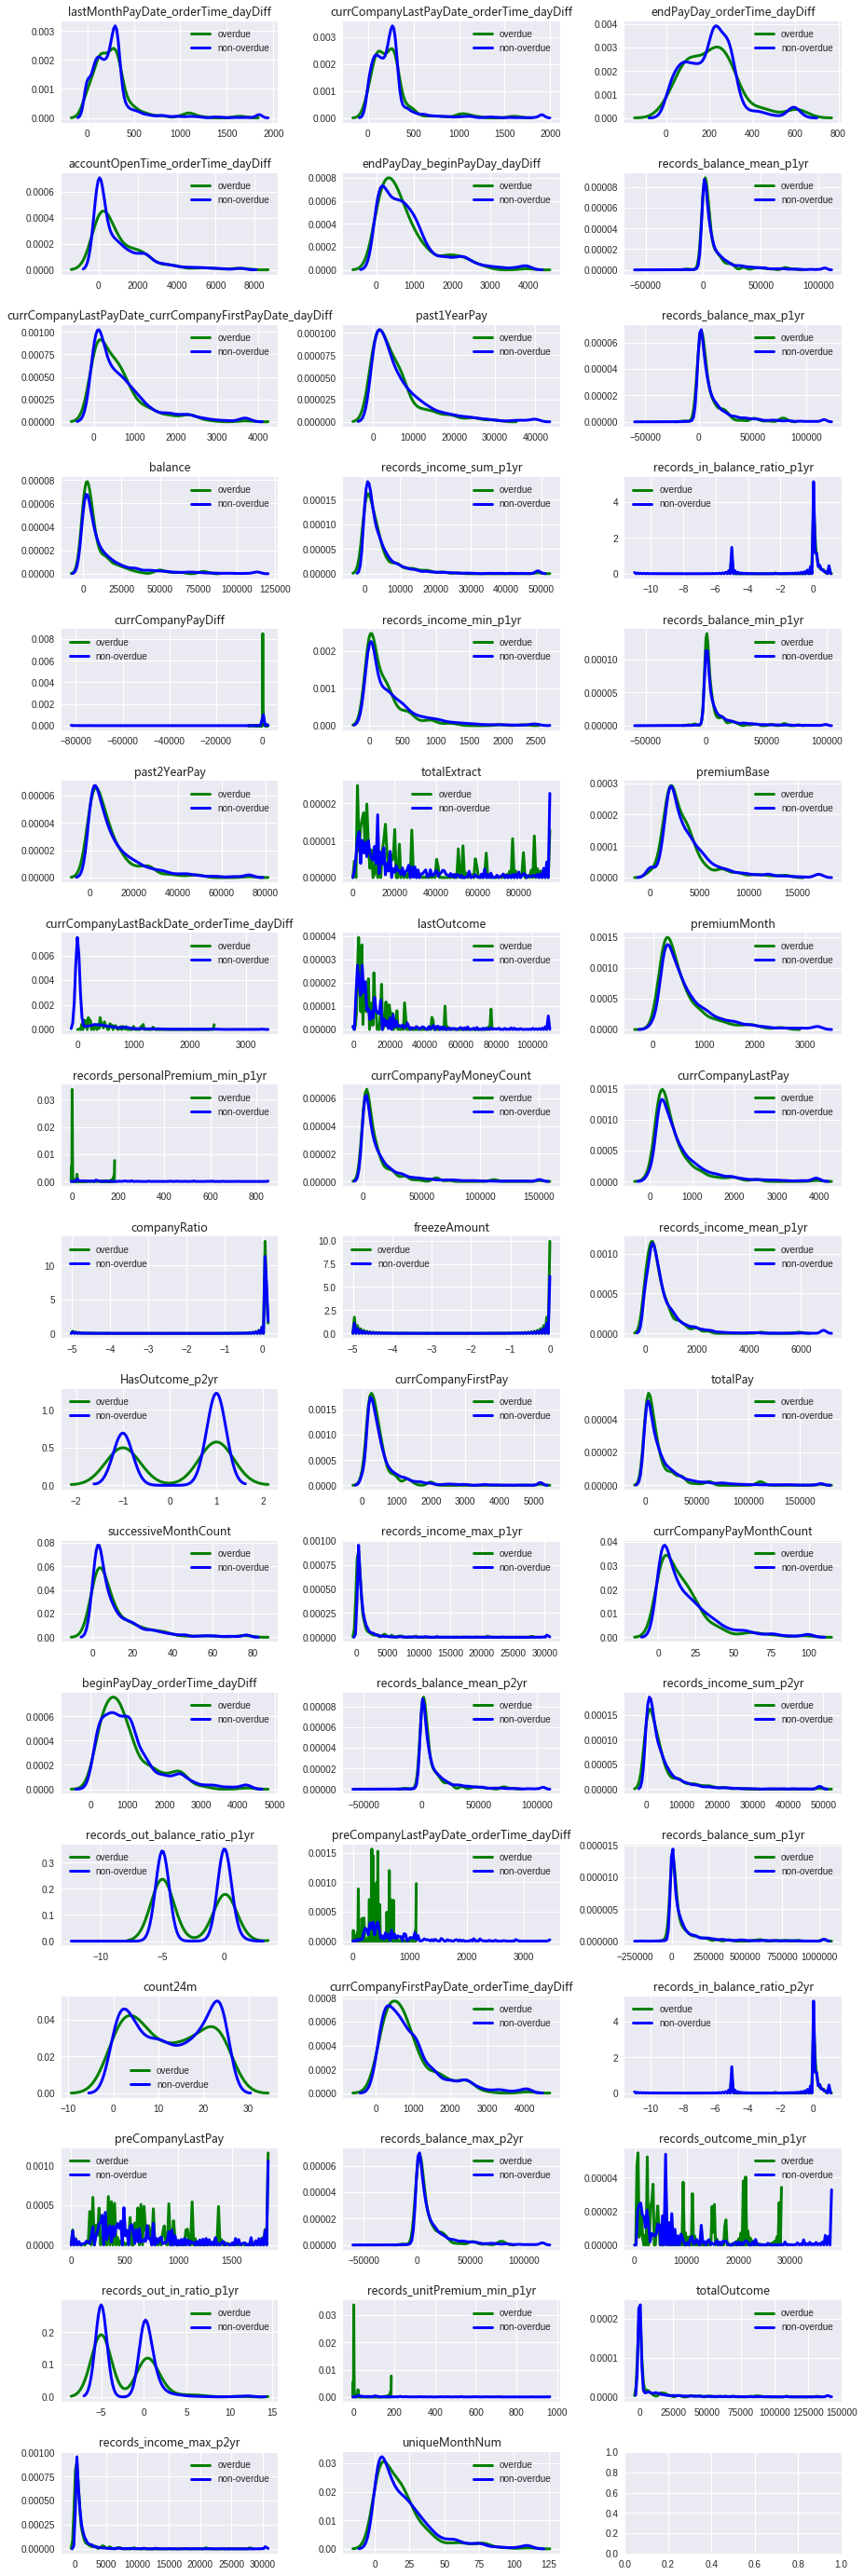

In [916]:
draw.displot_single(train_df,xgb_fea_list,'is_over',na=-5)

#### NA FILL

In [400]:
from collections import defaultdict
import csv
import os
def na_fill(df,numerical_col,tgt,directory='/data/tmp/wuchenyu',print_out=False):
    _dict = defaultdict(dict)
    _dict.update({'fea_name':'value'})
    for c in numerical_col:
        if df[c].isnull().any():
            temp_col = df[c].copy()
            temp_col_with_tgt = pd.concat([temp_col,df[tgt]],axis=1)
            temp_col.fillna(-999,inplace=True)
            temp = temp_col_with_tgt.groupby(temp_col).mean()
            comp_value = temp[[c]+[tgt]].loc[-999][tgt]
            temp['diff']=abs(temp[tgt]-comp_value)
            temp = temp.sort_values('diff',ascending=True)
            try:
                df[c] = df[c].fillna(temp[c].iloc[1])
            except:
                print(temp[c])
            _dict.update({c:temp[c].iloc[1]})
            if print_out:
                print('{} replace na values to {}'.format(c,temp[c].iloc[1]))
            del temp,temp_col
    w = csv.writer(open(os.path.join(directory,'fillna_table.csv'), "w"))
    for key, val in _dict.items():
        w.writerow([key, val])
    print('fillna table saved in {}.'.format(os.path.join(directory,"fillna_table.txt")))

In [401]:
# na_fill(train_df,new_numerical_col,'is_over',directory='/data/tmp/wuchenyu/funds')

fillna table saved in /data/tmp/wuchenyu/funds/fillna_table.txt.


In [917]:
train_df['freezeAmount'] = train_df['freezeAmount'].fillna(-1)
test_df['freezeAmount'] = test_df['freezeAmount'].fillna(-1)

In [918]:
for c in new_numerical_col:
    train_df[c] = train_df[c].fillna(np.mean(train_df[c]))
    test_df[c] = test_df[c].fillna(np.mean(train_df[c]))
for c in categorical_col:
    train_df[c] = train_df[c].fillna('NA')
    test_df[c] = test_df[c].fillna('NA')
for c in binary_col:
    train_df[c] = train_df[c].fillna(np.mean(train_df[c]))
    test_df[c] = test_df[c].fillna(np.mean(train_df[c]))

#### PearsonCorr

In [919]:
Temp_pear = PearsonCorr(train_df[new_numerical_col+new_categorical_col+binary_col], train_df['is_over'], feature_name=numerical_col).score()
Temp_pear['sort']=Temp_pear.pearson_corr.abs()
Temp_pear = Temp_pear.sort_values(by=['sort','p_value'],ascending=[False,True])
del Temp_pear['sort']
pearson_corr = set(Temp_pear.loc[Temp_pear['p_value']<0.05,'feature_name'].values)
print('Pearson相关系数<0.05的有{}个.'.format(len(pearson_corr)))
Temp_pear.drop_duplicates(subset='pearson_corr',keep='first').head(10)

Pearson相关系数<0.05的有40个.


,feature_name,pearson_corr,p_value
2,freezeAmount,0.060478,0.000741
22,currCompanyLastPay,-0.054754,0.002258
99,records_income_min_p5yr,-0.053680,0.002753
4,premiumMonth,-0.050958,0.004483
3,balance,-0.049887,0.005399
10,currCompanyFirstPay,-0.049698,0.005577
1,companyRatio,-0.047947,0.007497
0,personalRatio,-0.046236,0.009927
28,past1YearPay,-0.044026,0.014087
133,records_balance_min_p3yr,-0.041554,0.020501


#### Pairwise

In [920]:
Temp_pairwise = pairwise_corr(train_df[new_numerical_col], limit=0.1)
pairwise = set(Temp_pairwise.loc[Temp_pairwise['pearson_corr']<0.95,'var2'].values)
print('Pairwise相关性大于0.95的有{}个.'.format(len(pairwise)))
Temp_pairwise.head(10)

Pairwise相关性大于0.95的有295个.


,var1,var2,pearson_corr
15127,records_outcome_month_mean_p3yr,records_outcome_month_mean_p5yr,1.0
15115,records_outcome_month_mean_p1yr,records_outcome_month_mean_p3yr,1.0
15013,records_outcome_sum_p3yr,records_outcome_month_mean_p3yr,1.0
15121,records_outcome_month_mean_p2yr,records_outcome_month_mean_p3yr,1.0
14988,records_outcome_sum_p1yr,records_outcome_month_mean_p3yr,1.0
15024,records_outcome_sum_p5yr,records_outcome_month_mean_p3yr,1.0
15001,records_outcome_sum_p2yr,records_outcome_month_mean_p3yr,1.0
15116,records_outcome_month_mean_p1yr,records_outcome_month_mean_p5yr,1.0
15122,records_outcome_month_mean_p2yr,records_outcome_month_mean_p5yr,1.0
15014,records_outcome_sum_p3yr,records_outcome_month_mean_p5yr,1.0


#### IV值 (离散型特征)

In [921]:
woe_array = WOE().woe(train_df[categorical_col], train_df['is_over'])[1]
woe_dict = {name:woe for name, woe in zip(categorical_col, woe_array)}
Temp_iv_cat = pd.DataFrame.from_dict(woe_dict, orient='index').rename(columns={0: 'iv_value'}).sort_values('iv_value', ascending=0)
iv_cat = set(Temp_iv_cat[Temp_iv_cat['iv_value']>0.01].index.values)
print('IV值(离散特征)>0.01的有{}个.'.format(len(iv_cat)))
Temp_iv_cat.head(10)

IV值(离散特征)>0.01的有2个.


,iv_value
status,0.224541
premiumBaseCalculationType,0.047885


#### IV值 (数值型特征 需先用feature_discretion分箱

In [922]:
# ensure all numerical columns are continuous
iv_df = train_df.copy()
for col in new_numerical_col:
    iv_df[col] = iv_df[col].apply(lambda x: x + 0.000001)
    #print(col, type_of_target(iv_df[col]))
    
bin_df = pd.DataFrame(WOE().feature_discretion(iv_df[new_numerical_col]), columns=numerical_col)
woe_array = WOE().woe(bin_df, iv_df['is_over'])[1]

woe_dict = {name:woe for name, woe in zip(new_numerical_col, woe_array)}
Temp_iv_num = pd.DataFrame.from_dict(woe_dict, orient='index').rename(columns={0: 'iv_value'}).sort_values('iv_value', ascending=0)
iv_num = set(Temp_iv_num[Temp_iv_num['iv_value']>0.01].index.values)
print('IV值(数值特征)>0.01的有{}个.'.format(len(iv_num)))
Temp_iv_num.drop_duplicates(subset='iv_value',keep='first').head(10)

IV值(数值特征)>0.01的有145个.


,iv_value
records_outcome_mean_p1yr,0.472387
records_premiumBase_mean_p2yr,0.291408
companyRatio,0.069288
records_outcome_max_p1yr,0.067204
records_balance_mean_p5yr,0.066652
balance,0.064282
currCompanyLastPay,0.063861
personalRatio,0.063360
premiumMonth,0.061231
currCompanyFirstPay,0.058627


#### 卡方检验 （离散型变量与是否逾期）

In [924]:
from sklearn.preprocessing import MinMaxScaler
dff =pd.DataFrame(columns=categorical_col+binary_col)
for col in categorical_col+binary_col:
    dff[col] = train_df[col].astype('category').cat.codes
# categorical变量 encode
dff =pd.DataFrame(columns=categorical_col+binary_col)
for col in categorical_col+binary_col:
    dff[col] = train_df[col].astype('category').cat.codes
dff = pd.DataFrame(data=MinMaxScaler().fit_transform(dff[categorical_col+binary_col]),columns=categorical_col+binary_col)
# 高cardinality feature容易有高chi2值与强显著性
Temp_chi = Chi2Select(dff[categorical_col+binary_col], train_df['is_over'], feature_name=categorical_col+binary_col).score()
chi_cat = set(Temp_chi.loc[Temp_chi['p_value']>0.05,'feature_name'].values) | set(Temp_chi.loc[Temp_chi['chi2']<1,'feature_name'].values) | \
set(Temp_chi.loc[Temp_chi['p_value'].isnull()==True,'feature_name'].values)
print('卡方检验p值(离散特征)>0.05的有{}个.'.format(len(chi_cat)))
Temp_chi.head(10)

卡方检验p值(离散特征)>0.05的有24个.


,feature_name,chi2,p_value
5,isCompanyEverPay,4.786333,0.028686
11,HasOutcome_p2yr,3.051820,0.080647
10,HasOutcome_p1yr,2.857156,0.090968
12,HasOutcome_p3yr,2.677554,0.101772
14,accountOpenTime_orderTime_dayDiff_isna,2.547702,0.110455
13,HasOutcome_p5yr,2.420694,0.119742
4,isCurrCompanyHasBack,2.180332,0.139784
6,freezeAmount_isna,1.719085,0.189811
0,premiumBaseCalculationType,1.226168,0.268154
21,currCompanyLastBackDate_orderTime_dayDiff_isna,0.913530,0.339179


#### 互信息

In [925]:
# create a list to store columns that are categorical type
features = new_numerical_col+new_categorical_col+binary_col
# tmp_train_df = train_df.fillna(value=data.mean(),inplace=True)
Temp_mutual = train_df.copy()

store_list = []
start=time.time()
for feature in features:
    if type_of_target(Temp_mutual[feature]) == 'continuous':
        store_list.append(0)  
    else:
        store_list.append(1)
del Temp_mutual
Temp_mutual = MutualInfo(train_df[features], train_df['is_over'], 
           feature_name=features, model_type='class', 
           discrete_features=np.array(store_list)).score()
end=time.time()-start
mutual = set(Temp_mutual[Temp_mutual['MutualInfo']<0.01]['feature_name'])
print('Take {}sec.'.format(end))
print('互信息值(数值特征)<0.01的有{}个.'.format(len(mutual)))
Temp_mutual.head(10)

Take 15.61150336265564sec.
互信息值(数值特征)<0.01的有329个.


,feature_name,MutualInfo
18,totalPay,0.013145
103,records_income_max_p1yr,0.010701
225,records_outcome_month_mean_p5yr,0.010466
26,companyCount,0.009733
172,records_unitPremium_max_p6m,0.009414
64,records_personalPremium_min_p5yr,0.008673
74,records_personalPremium_sum_p6m,0.008638
321,accountOpenTime_orderTime_dayDiff_isna,0.008624
96,records_income_min_p1yr,0.008512
27,past1YearCompanyCount,0.008494


### 通过RF和Lasso跑特征重要性

In [926]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.model_selection import train_test_split

X = train_df[new_numerical_col+categorical_col+binary_col+new_categorical_col]
y = train_df['is_over']
df_X_train, df_X_validation, df_y_train, df_y_validation = train_test_split(X, y, train_size=0.75, random_state=123)

woe_dict = {}
for c in categorical_col+binary_col:
    bin_num = len(df_X_train[c].unique())
    woe = WoE(5, 10, v_type='d', t_type='d')
    q = woe.fit(df_X_train[c], df_y_train)
    map_list = q.bins[['bins','woe']].set_index('bins').to_dict(orient='dict')['woe']
    woe_dict[c] = map_list
    df_X_train[c] = df_X_train[c].map(map_list)    
#     df_X_train[c].fillna(0,inplace=True)
    df_X_validation[c] = df_X_validation[c].map(map_list)
#     df_X_validation[c].fillna(0,inplace=True)
    test_df[c] = test_df[c].map(map_list)
#     test_df[c] = test_df[c].fillna(0,inplace=True)
# #     fig = woe.plot()
#    print(c,fig)

names = new_numerical_col+categorical_col+binary_col+new_categorical_col
ranks = {}

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 5), ranks)
    return dict(zip(names, ranks ))

X_train = df_X_train[new_numerical_col+categorical_col+binary_col+new_categorical_col].values
X_test = df_X_validation[new_numerical_col+categorical_col+binary_col+new_categorical_col].values
y_train = df_y_train.values
y_test = df_y_validation.values

X = X_train
Y = y_train

rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

lasso = Lasso(alpha=1)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

r_mean = {}
for name in names:
    r_mean[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 5)
ranks["Mean"] = r_mean

MODEL = pd.DataFrame.from_dict(ranks)
MODEL.sort_values(by='RF',ascending=False,inplace=True)
useful_fea = list(MODEL[MODEL['RF']>0.002].index)
MODEL

,Lasso,Mean,RF
premiumBase,0.00423,0.50212,1.00000
endPayDay_orderTime_dayDiff,0.06193,0.50297,0.94401
currCompanyLastPay,0.05093,0.38106,0.71118
currCompanyPayDiff,0.00487,0.32705,0.64923
accountOpenTime_orderTime_dayDiff,0.10094,0.37200,0.64305
lastMonthPayDate_orderTime_dayDiff,0.00000,0.28082,0.56165
lastOutcome,0.02283,0.29175,0.56066
successiveMonthCount,0.00000,0.25278,0.50557
currCompanyLastPayDate_currCompanyFirstPayDate_dayDiff,0.00000,0.24641,0.49282
totalPay,0.01673,0.23833,0.45993


In [927]:
MODEL[['Lasso']].sort_values(by='Lasso',ascending=False)

,Lasso
preCompanyLastPayDate_orderTime_dayDiff,1.00000
premiumMonth,0.34351
currCompanyLastBackDate_orderTime_dayDiff,0.27334
currCompanyFirstPay,0.19916
endPayDay_beginPayDay_dayDiff,0.16851
records_outcome_max_p1yr,0.13438
records_unitPremium_sum_p1yr,0.12657
records_balance_max_p1m,0.12536
records_balance_sum_p1m,0.10589
accountOpenTime_orderTime_dayDiff,0.10094


In [928]:
from sklearn.metrics import roc_curve, auc
auc_dict ={}
for c in new_numerical_col+new_categorical_col+binary_col+new_categorical_col:
    try:
        lm = sm.Logit(df_y_train,sm.add_constant(df_X_train[c], prepend=False, has_constant='add')).fit(disp=0)
        predictions = lm.predict(sm.add_constant(df_X_train[c], prepend=False, has_constant='add'))
        fpr, tpr, thresholds = roc_curve(df_y_train,predictions)
        roc_auc = auc(fpr, tpr)
        auc_dict.update({c:roc_auc})
    except:
        continue
auc_df = pd.DataFrame.from_dict(auc_dict,orient='index')
auc_df.sort_values(0,ascending=0).drop_duplicates(0,keep='first')

,0
premiumMonth,0.575819
currCompanyLastPay,0.572008
balance,0.555412
past1YearPay,0.553296
past2YearPay,0.552820
personalRatio,0.552262
companyRatio,0.551929
currCompanyFirstPay,0.550936
currCompanyPayMoneyCount,0.549854
totalPay,0.549226


In [929]:
select_fea = list(set(Temp_pear.drop_duplicates(subset='pearson_corr',keep='first').head(15).feature_name.values)|\
set(Temp_mutual.feature_name.head(15).values)|\
set(Temp_iv_num.drop_duplicates(subset='iv_value',keep='first').head(15).index)|\
set(Temp_iv_cat.drop_duplicates(subset='iv_value',keep='first').head(15).index)|\
set(MODEL[['RF']].sort_values(by='RF',ascending=0).head(15).index.values)\
|set(MODEL[['Lasso']].sort_values(by='Lasso',ascending=0).head(15).index.values)|\
set(auc_df.sort_values(0,ascending=0).drop_duplicates(0,keep='first').head(15).index.values))

In [930]:
select_fea

['currCompanyFirstPay',
 'records_balance_min_p3yr',
 'records_out_in_ratio_p2yr',
 'endPayDay_orderTime_dayDiff',
 'records_income_min_p1m',
 'records_balance_min_p1yr',
 'currCompanyLastBackDate_orderTime_dayDiff_isna',
 'companyRatio',
 'lastMonthPayDate_orderTime_dayDiff',
 'records_balance_sum_p1m',
 'records_personalPremium_min_p5yr',
 'records_unitPremium_max_p6m',
 'preCompanyLastPayDate_orderTime_dayDiff',
 'premiumMonth',
 'records_income_max_p2yr',
 'records_balance_mean_p5yr',
 'records_outcome_max_p1yr',
 'companyCount',
 'records_outcome_month_mean_p5yr',
 'totalExtract',
 'endPayDay_beginPayDay_dayDiff',
 'currCompanyLastPay',
 'records_income_min_p5yr',
 'status',
 'records_outcome_sum_p1yr',
 'past1YearCompanyCount',
 'accountOpenTime_orderTime_dayDiff',
 'beginPayDay_orderTime_dayDiff',
 'balance',
 'records_unitPremium_sum_p1yr',
 'personalRatio',
 'records_balance_max_p1m',
 'past2YearPay',
 'currCompanyPayMoneyCount',
 'records_personalPremium_sum_p6m',
 'currCompa

In [931]:
from utils.boruta.boruta_py import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# X = df_X_train.drop('is_over', axis=1)
X = df_X_train.copy()
features = select_fea
# features = new_numerical_col+categorical_col+binary_col
X = X[features]
y = df_y_train

for col in list(X):
    X.loc[X[col].isnull(), col] = np.mean(X[col])
    
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight='balanced', max_depth=4)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
boruta_selector.fit(X.values, y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	54
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	54
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	54
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	54
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	55
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	55
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	55
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	55
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	55
I

BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fdd60086948>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7fdd60086948>,
     two_step=True, verbose=2)

In [932]:
feature_df = pd.DataFrame(X.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

In [933]:
feature_df

,features,rank
0,records_income_min_p3yr,2
1,records_income_min_p1yr,2
2,records_income_min_p5yr,2
3,currCompanyLastPay,4
4,premiumMonth,5
5,preCompanyLastPayDate_orderTime_dayDiff,5
6,currCompanyFirstPay,7
7,endPayDay_orderTime_dayDiff,8
8,currCompanyPayMoneyCount,9
9,premiumBase,10


In [ ]:
# tmp_feature_df = feature_df.copy()

In [ ]:
# tmp_sfs_fea_selection = feature_df.ix[feature_df.features.isin(select_fea)]

In [ ]:
# tmp_sfs_fea_selection = tmp_sfs_fea_selection.reset_index()
# tmp_sfs_fea_selection = tmp_sfs_fea_selection.drop('index',axis=1)

In [934]:
x_train = df_X_train[list(feature_df['features'][:40])]
# x_train = df_X_train[list(feature_df.ix[feature_df.features.isin(feature_df)]['features'][:40])]
model = LogisticRegression(C=1, penalty='l1')
SklearnFeatureSelector(model).run(x_train.values, df_y_train.values, k_features=30, floating=0, scoring='roc_auc', cv=3,
                                  out_path='/data/tmp/wuchenyu/funds/')

[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished

[2018-03-20 13:47:33] Features: 1/30 -- score: 0.57665403239[Parallel(n_jobs=-1)]: Done   8 out of  39 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  28 out of  39 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.4s finished

[2018-03-20 13:47:35] Features: 2/30 -- score: 0.597572583628[Parallel(n_jobs=-1)]: Done   7 out of  38 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  27 out of  38 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.5s finished

[2018-03-20 13:47:37] Features: 3/30 -- score: 0.608060861168[Parallel(n_jobs=-1)]: Done   6 out of  37 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out


Saving Metric Dict ...



[2018-03-20 13:49:52] Features: 30/30 -- score: 0.651871669915

In [935]:
sfs_fea = pd.read_csv('/data/tmp/wuchenyu/funds/sequential_selector_metric_df.csv')
sfs_fea

,Unnamed: 0,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
0,1,0.576654,0.085343,[ 0.61764706 0.58610896 0.52620608],"(4,)",0.037925,0.026817
1,2,0.597573,0.111150,[ 0.65478651 0.60366978 0.53426147],"(4, 5)",0.049393,0.034926
2,3,0.608061,0.081338,[ 0.65787176 0.5930976 0.57321322],"(4, 5, 31)",0.036145,0.025558
3,4,0.628732,0.060662,[ 0.66242687 0.62732707 0.59644133],"(4, 5, 36, 31)",0.026957,0.019061
4,5,0.634528,0.073331,[ 0.67964316 0.62011539 0.60382668],"(4, 5, 36, 23, 31)",0.032587,0.023042
5,6,0.639406,0.076154,[ 0.68681782 0.61004877 0.621352 ],"(4, 5, 36, 7, 23, 31)",0.033841,0.023929
6,7,0.644757,0.032047,[ 0.6606805 0.64747517 0.62611674],"(4, 5, 36, 7, 20, 23, 31)",0.014241,0.010070
7,8,0.648660,0.037235,[ 0.6583229 0.66228514 0.62537225],"(4, 5, 36, 7, 38, 20, 23, 31)",0.016546,0.011700
8,9,0.653146,0.031132,[ 0.66091335 0.66481294 0.63371054],"(4, 5, 7, 17, 20, 23, 31, 36, 38)",0.013835,0.009783
9,10,0.654172,0.030744,[ 0.6630381 0.66460477 0.63487195],"(4, 5, 7, 17, 20, 23, 28, 31, 36, 38)",0.013662,0.009660


In [936]:
sfs_fea.feature_idx.iloc[19]

'(3, 4, 5, 6, 7, 12, 13, 15, 17, 20, 23, 24, 28, 30, 31, 33, 35, 36, 37, 38)'

In [937]:
feature_df[feature_df.index.isin([3, 4, 5, 6, 7, 12, 13, 15, 17, 20, 23, 24, 28, 30, 31, 33, 35, 36, 37, 38])]

,features,rank
3,currCompanyLastPay,4
4,premiumMonth,5
5,preCompanyLastPayDate_orderTime_dayDiff,5
6,currCompanyFirstPay,7
7,endPayDay_orderTime_dayDiff,8
12,balance,12
13,past1YearPay,14
15,endPayDay_beginPayDay_dayDiff,16
17,currCompanyPayDiff,18
20,totalExtract,20


In [418]:
def stepwise_lr(x_train, target, lm, prune_cnt=0,print_out=0):
    i = 0
    while True:
        zs_pval = pd.DataFrame([(v[0], abs(float(v[3])), float(v[4]))
                                for v in lm.summary().tables[1].data[1:-1]], columns=['var', 'zscore', 'pval'])
        if np.sum(zs_pval['pval'] > 0.01):
            zs_pval.sort_values('pval', ascending=False, inplace=True)
            zs_pval.reset_index(inplace=True, drop=True)
            print('Iter {:2d} | pvalue={:.3f}: remove p-val vars "{}"'.format(i, zs_pval.loc[0, 'pval'], zs_pval.loc[0, 'var']))
        elif prune_cnt:
            zs_pval.sort_values('zscore', ascending=False, inplace=True)
            zs_pval.reset_index(inplace=True, drop=True)
            print('Iter {:2d} | pvalue={:.3f}: remove least abs z-score vars "{}"'.format(i, zs_pval.loc[0, 'zscore'], zs_pval.loc[0, 'var']))
            prune_cnt -= 1
        else:
            return lm, zs_pval['var'].tolist()

        i += 1
        var_lr = zs_pval.loc[1:, 'var'].tolist()
        lm, pred = lr_model(x_train[var_lr], target, rtn_pred=True, toplot=False)

In [938]:
feature_df

,features,rank
0,records_income_min_p3yr,2
1,records_income_min_p1yr,2
2,records_income_min_p5yr,2
3,currCompanyLastPay,4
4,premiumMonth,5
5,preCompanyLastPayDate_orderTime_dayDiff,5
6,currCompanyFirstPay,7
7,endPayDay_orderTime_dayDiff,8
8,currCompanyPayMoneyCount,9
9,premiumBase,10


In [955]:
bivar(train_df,'freezeAmount_isna',\
      target='is_over',t_type='c',cut='qcut',bins=50,cut_num=50,cut_start='none')

Cannot find best quantile binning cut.
Start looking for equidistance binning cut.

since too many values in one bin, so we start use cut method!


---> Predict with LR model
KS=0.128, AUC=0.57, N=2331
At threshold=0.06, TPR=0.06, 8 out of 139
At threshold=0.06, TPR=0.06, 131 out of 2192
Ave_target: [ 0.03433476  0.02575107  0.05579399  0.06008584  0.06008584  0.07725322
  0.06866953  0.05579399  0.08154506  0.07725322]
Ave_predicted: [ 0.02892527  0.04593198  0.05348852  0.05844575  0.06201494  0.06482473
  0.06744619  0.0694397   0.0714716   0.07424068]


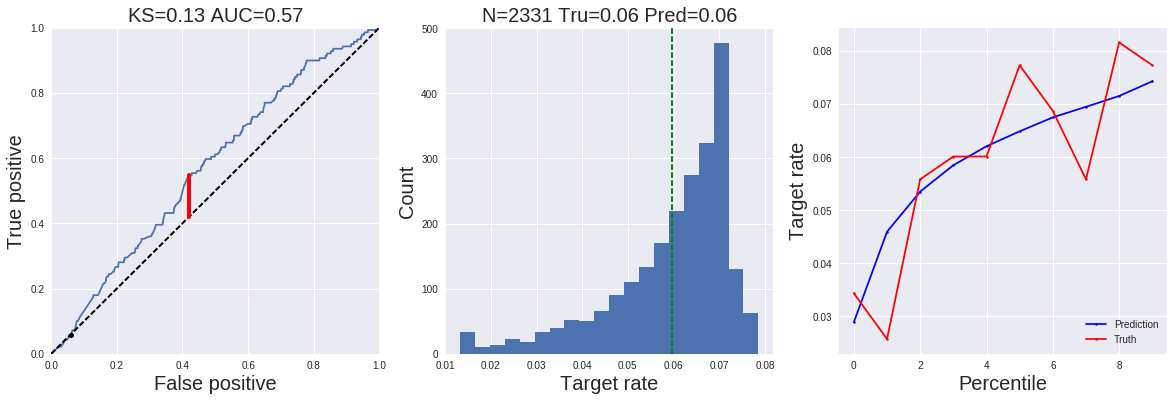

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_over   No. Observations:                 2331
Model:                          Logit   Df Residuals:                     2329
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Mar 2018   Pseudo R-squ.:                0.008259
Time:                        13:53:10   Log-Likelihood:                -522.34
converged:                       True   LL-Null:                       -526.69
                                        LLR p-value:                  0.003182
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
currCompanyLastPay    -0.0005      0.000     -2.646      0.008      -0.001      -0.000
const                 -2.4626      0.133    -18.504      0.000      -2.723      -2.202
======================================================================================
"""

In [959]:
var_lr = [
    'currCompanyLastPay'
]
# var_lr = [
#     'records_income_min_p3yr',
#     'preCompanyLastPayDate_orderTime_dayDiff',
#     'isCurrCompanyHasBack'
#          ]
lm = sm.Logit(df_y_train, sm.add_constant(df_X_train[var_lr], prepend=False)).fit(disp=0)
# lm,var_lr = stepwise_lr(df_X_train[var_lr], df_y_train, lm)
_ = lr_model(df_X_train[var_lr].values, df_y_train, lm, rtn_pred=False)
plt.show()
lm.summary()

---> Predict with LR model
KS=0.146, AUC=0.56, N=778
At threshold=0.073, TPR=0.09, 5 out of 57
At threshold=0.073, TPR=0.07, 51 out of 721
Ave_target: [ 0.03846154  0.08974359  0.05128205  0.05128205  0.06410256  0.08974359
  0.05128205  0.08974359  0.12820513  0.07894737]
Ave_predicted: [ 0.0279786   0.04567783  0.05296439  0.05812686  0.06210289  0.06454174
  0.0672106   0.06914585  0.07133815  0.07436468]


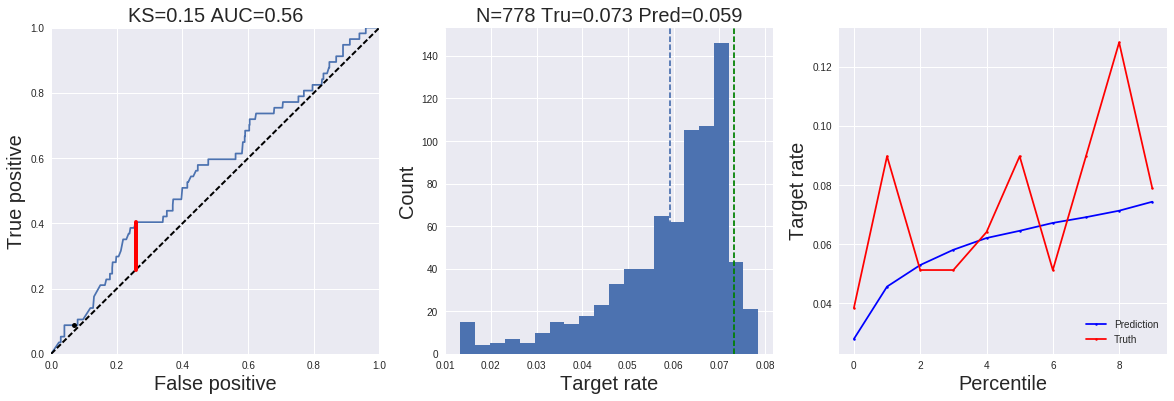

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_over   No. Observations:                 2331
Model:                          Logit   Df Residuals:                     2329
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Mar 2018   Pseudo R-squ.:                0.008259
Time:                        13:53:11   Log-Likelihood:                -522.34
converged:                       True   LL-Null:                       -526.69
                                        LLR p-value:                  0.003182
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
currCompanyLastPay    -0.0005      0.000     -2.646      0.008      -0.001      -0.000
const                 -2.4626      0.133    -18.504      0.000      -2.723      -2.202
======================================================================================
"""

In [960]:
_ = lr_model(df_X_validation[var_lr].values, df_y_validation, lm, rtn_pred=False)
plt.show()
lm.summary()

---> Predict with LR model
KS=0.217, AUC=0.63, N=882
At threshold=0.045, TPR=0.08, 3 out of 40
At threshold=0.045, TPR=0.04, 36 out of 842
Ave_target: [ 0.01136364  0.03409091  0.04545455  0.02272727  0.03409091  0.04545455
  0.05681818  0.02272727  0.10227273  0.07954545]
Ave_predicted: [ 0.02854385  0.04529429  0.05209231  0.05720796  0.06145617  0.06434124
  0.06697149  0.06901046  0.07112945  0.07469182]


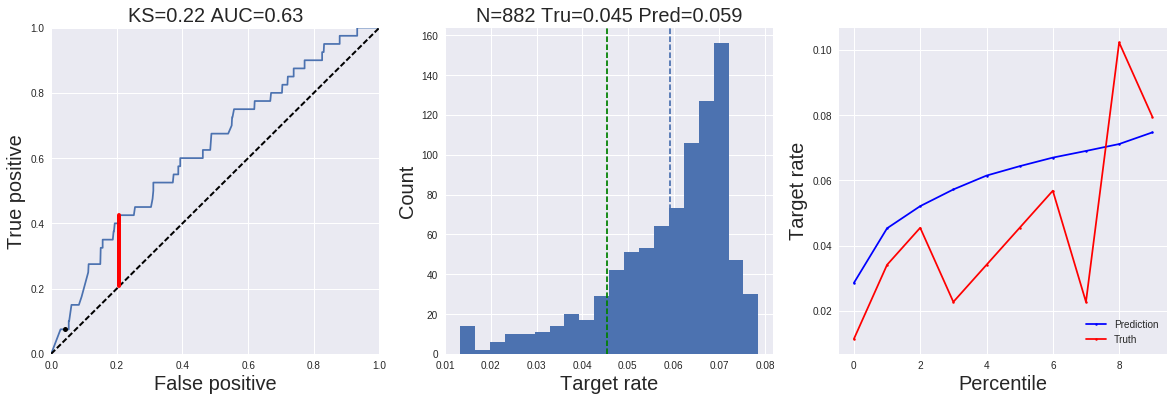

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_over   No. Observations:                 2331
Model:                          Logit   Df Residuals:                     2329
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Mar 2018   Pseudo R-squ.:                0.008259
Time:                        13:53:15   Log-Likelihood:                -522.34
converged:                       True   LL-Null:                       -526.69
                                        LLR p-value:                  0.003182
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
currCompanyLastPay    -0.0005      0.000     -2.646      0.008      -0.001      -0.000
const                 -2.4626      0.133    -18.504      0.000      -2.723      -2.202
======================================================================================
"""

In [961]:
_ = lr_model(test_df[var_lr].values, test_df['is_over'], lm, rtn_pred=False)
plt.show()
lm.summary()

In [851]:
bivar(new_df,'currCompanyLastPay',\
      target='is_over',t_type='c',cut='F-D',bins=50,cut_num=50,cut_start='tail')

In [853]:
bivar(pd.concat([df_X_validation,df_y_validation],axis=1),'currCompanyLastPay',\
      target='is_over',t_type='c',cut='F-D',bins=50,cut_num=20,cut_start='tail')

In [856]:
bivar(test_df,'currCompanyLastPay',target='is_over',t_type='c',cut='F-D',bins=50,\
      cut_num=20,cut_start='tail')

In [168]:
from pyecharts import Bar,Line,Scatter,Overlap
import math
def bivar(data,feature,t_type,target=None,draw_type='line',bins=20,tree_depth=4,woe = None,d_reorder=False,cut='none',custom_bin=[],\
          cut_num=None,cut_start=None,fill_na=-99999,text_print=True):
    # data is dataframe
    # feature is feature name
    # target is your target name, should be binary integer
    # t_type has two selection, 'c' or 'd', 'c' means continue, 'd' means discreate
    # draw_type has line and scatter
    # bins means you can choose how many bins to cut by yourself
    # tree_depth is only working for decision tree binning
    # woe is only working for woe binning
    # cut has three selection, 'none','qcut','cut','F-D' only for numerical col
    # d_reorder will sort categorical values and reorder it
    # example bivar(df,'feature2','is_over','c')
    # make sure feature and target in your dataframe
    data=data;feature=feature;target=target;t_type=t_type
    X = data[feature]
    if target != None:
        Y = data[target]
    if fill_na != -99999:
        X = X.fillna(fill_na)
    missing_exist = X.isnull().any()
    #fillna value if it has.
    if cut == 'none':
        if (target != None) & (missing_exist == True):
            # Data preprocessing
            temp_df = data[[feature,target]].fillna('missing').copy()
            feature_a = temp_df[[feature,target]].groupby(feature).size()
            feature_b = temp_df[[feature,target]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        elif (target != None) & (missing_exist == False):
            # Data preprocessing
            temp_df = data[[feature,target]].fillna(fill_na).copy()
            feature_a = temp_df[[feature,target]].groupby(feature).size()
            feature_b = temp_df[[feature,target]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        elif (target == None) & (missing_exist == False):
            # Data preprocessing
            temp_df = data[[feature]].fillna(fill_na).copy()
            feature_a = temp_df[[feature]].groupby(feature).size()
            feature_b = temp_df[[feature]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        else:
            # Data preprocessing
            temp_df = data[[feature]].fillna('missing').copy()
            feature_a = temp_df[[feature]].groupby(feature).size()
            feature_b = temp_df[[feature]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)   
        # check if has missing value in dataframe
        # Data preprocessing with missing value
        if missing_exist:
            if (t_type == 'c'):
                missing_df = feature_final.loc['missing':'missing']
                feature_final = feature_final[feature_final.index != 'missing']
                index_list = list(pd.cut(feature_final.index, bins = bins))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
                if target != None:
                    feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
            elif target != None:
                feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
        # Data preprocessing w/o missing value
        else:
            if (t_type == 'c'):
                index_list = list(pd.cut(feature_final.index, bins = bins))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
                feature_final.index = list(OrderedSet(index_list))
                if target != None:
                    feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
            elif target != None:
                feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
        feature_final.reset_index(inplace=True)
        feature_final.rename(columns={'index':feature},inplace=True)
    if cut == 'custom':
        if (target != None) & (missing_exist == True):
            # Data preprocessing
            temp_df = data[[feature,target]].fillna('missing').copy()
            feature_a = temp_df[[feature,target]].groupby(feature).size()
            feature_b = temp_df[[feature,target]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        elif (target != None) & (missing_exist == False):
            # Data preprocessing
            temp_df = data[[feature,target]].fillna(fill_na).copy()
            feature_a = temp_df[[feature,target]].groupby(feature).size()
            feature_b = temp_df[[feature,target]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        elif (target == None) & (missing_exist == False):
            # Data preprocessing
            temp_df = data[[feature]].fillna(fill_na).copy()
            feature_a = temp_df[[feature]].groupby(feature).size()
            feature_b = temp_df[[feature]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        else:
            # Data preprocessing
            temp_df = data[[feature]].fillna('missing').copy()
            feature_a = temp_df[[feature]].groupby(feature).size()
            feature_b = temp_df[[feature]].groupby(feature).sum()
            feature_final = pd.concat([feature_a,feature_b],axis=1)
            feature_final.rename(columns = {0:'total'},inplace=True)
        # check if has missing value in dataframe
        # Data preprocessing with missing value
        if missing_exist:
            if ((t_type == 'c') & (len(temp_df[feature].unique())>=bins)):
                missing_df = feature_final.loc['missing':'missing']
                feature_final = feature_final[feature_final.index != 'missing']
                index_list = list(pd.cut(feature_final.index, bins = custom_bin))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
                if target != None:
                    feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
            elif target != None:
                feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
        # Data preprocessing w/o missing value
        else:
            if ((t_type == 'c') & (len(temp_df[feature].unique())>=bins)):
                index_list = list(pd.cut(feature_final.index, bins = custom_bin))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
                feature_final.index = list(OrderedSet(index_list))
                if target != None:
                    feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
            elif target != None:
                feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
        feature_final.reset_index(inplace=True)
        feature_final.rename(columns={'index':feature},inplace=True)
    if ((t_type == 'c') & (cut == 'F-D') & (target != None)):
        if missing_exist == True:
            temp_df = data[[feature,target]].fillna('missing').copy()
        elif missing_exist != True:
            temp_df = data[[feature,target]].fillna(fill_na).copy()
        # Data preprocessing
        feature_a = temp_df[[feature,target]].groupby(feature).size()
        feature_b = temp_df[[feature,target]].groupby(feature).sum()
        feature_final = pd.concat([feature_a,feature_b],axis=1)
        feature_final.rename(columns = {0:'total'},inplace=True)
        # check if has missing value in dataframe
        # Data preprocessing with missing value
        if missing_exist:
            if ((t_type == 'c')):
                missing_df = feature_final.loc['missing':'missing']
                feature_final = feature_final[feature_final.index != 'missing']
                missing_temp_df = temp_df[temp_df[feature]=='missing']
                missing_temp_df = pd.DataFrame(missing_temp_df.groupby(feature).size())
                missing_temp_df.rename(columns={0:target},inplace=True)
                missing_over_size = temp_df[temp_df[feature]=='missing'][temp_df[target]==1].shape[0]
                missing_temp_df[target]['missing'] = missing_over_size
                non_missing_temp_df = temp_df[temp_df[feature]!='missing']
                non_missing_temp_df.index = non_missing_temp_df[feature]

                Q1 = non_missing_temp_df[feature].astype(float).describe()['25%']
                Q3 = non_missing_temp_df[feature].astype(float).describe()['75%']
                min_value = non_missing_temp_df.index.min()
                max_value = non_missing_temp_df.index.max()
                bins_list = [min_value-0.0001]
                temp_value = min_value
                F_D = 2*(Q3-Q1)/math.pow(non_missing_temp_df.shape[0],1/3)
                if F_D == 0:
                    print('since too many values in one bin, so we start use cut method!')
                    print('='*60)
                    try:
                        result = bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type,cut_num=cut_num,cut_start=cut_start)
                        return result
                    except:
                        return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
                while temp_value < max_value:
                    temp_value += F_D
                    bins_list.append(temp_value)
                index_list = list(pd.cut(feature_final.index, bins = bins_list))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
        # Data preprocessing w/o missing value
        else:
            if ((t_type == 'c')):
                non_missing_temp_df = temp_df.copy()
                non_missing_temp_df.index = non_missing_temp_df[feature]
                Q1 = non_missing_temp_df[feature].astype(float).describe()['25%']
                Q3 = non_missing_temp_df[feature].astype(float).describe()['75%']
                min_value = non_missing_temp_df.index.min()
                max_value = non_missing_temp_df.index.max()
                bins_list = [min_value-0.0001]
                temp_value = min_value
                F_D = 2*(Q3-Q1)/math.pow(non_missing_temp_df.shape[0],1/3)
                if F_D == 0:
                    print('since too many values in one bin, so we start use cut method!')
                    print('='*60)
                    try:
                        result = bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type,cut_num=cut_num,cut_start=cut_start)
                        return result
                    except:
                        return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
                while temp_value < max_value:
                    temp_value += F_D
                    bins_list.append(temp_value)
                index_list = list(pd.cut(feature_final.index, bins = bins_list))
                feature_final.index=index_list
                feature_final.index.name=feature
                feature_final = feature_final.groupby(feature_final.index).sum()
                feature_final = feature_final.reindex(list(OrderedSet(index_list)))
                feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
        feature_final.reset_index(inplace=True)
        feature_final.rename(columns={'index':feature},inplace=True)
        feature_final[target+'_rate'] = feature_final[target]/feature_final['total']
    if ((t_type == 'c') & (cut == 'qcut') & (target != None)):
        try:
            feature_final = numerical_binning_qcut_for_draw(numerical_binning_qcut(X,Y,n=bins,text_print=text_print),X,Y,missing_exist=missing_exist)
        except:
            print('since too many values in one bin, so we start use cut method!')
            print('='*60)
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
    elif ((t_type == 'c') & (cut == 'cut')& (target != None)):
        try:
            feature_final = numerical_binning_qcut_for_draw(numerical_binning_cut(X,Y,n=bins),X,Y,missing_exist=missing_exist)
        except:
            print('since too many values in one bin, so we start use cut method!')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
    elif ((t_type == 'c') & (cut == 'dtree')& (target != None)):
        try:
            feature_final = DecisionTreeBinning(data,feature,target,max_depth=tree_depth,missing_exist=False)
        except:
            print('since too many values in one bin, so we start use cut method!')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
    elif((t_type == 'c') & (cut == 'woe')& (target != None)):
        try:
            feature_final = woe_binning_cut_for_draw(X,Y,woe)
        except:
            print('since too many values in one bin, so we start use cut method!')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
    if (cut_num != None) & (cut_start == 'start') & (t_type == 'c'):
        try:
            new_left = feature_final[feature_final['total']<cut_num][feature].iloc[0].left
            new_right = feature_final[feature_final['total']>cut_num][feature].iloc[0].left
        except:
            print('data cannot be cut from head.')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
        new_total = feature_final.iloc[:feature_final[feature_final['total']>=cut_num].index[0]].total.sum()
        new_is_over = feature_final.iloc[:feature_final[feature_final['total']>=cut_num].index[0]][target].sum()
        new_tmp_df = pd.DataFrame({feature:[pd.Interval(left=new_left, right=new_right)],'total':[new_total],\
                     target:[new_is_over],target+'_rate':[new_is_over/new_total]})
        feature_final = pd.concat([new_tmp_df,feature_final.iloc[feature_final[feature_final['total']>cut_num].index[0]:]],\
                                  axis=0).reset_index()
        feature_final = feature_final.drop('index',axis=1)
    elif (cut_num != None) & (cut_start == 'tail') & (t_type == 'c'):
        try:
            new_left = feature_final[feature_final['total']>=cut_num][feature].iloc[-1].right
            new_right = feature_final[feature_final['total']<cut_num][feature].iloc[-1].right
        except:
            print('data cannot be cut from tail.')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
        new_total = feature_final.iloc[feature_final[feature_final['total']>=cut_num].index[-1]+1:].total.sum()
        new_is_over = feature_final.iloc[feature_final[feature_final['total']>=cut_num].index[-1]+1:][target].sum()
        new_tmp_df = pd.DataFrame({feature:[pd.Interval(left=new_left, right=new_right)],'total':[new_total],\
                     target:[new_is_over],target+'_rate':[new_is_over/new_total]})
        feature_final = pd.concat([feature_final.iloc[:feature_final[feature_final['total']>cut_num].index[-1]+1],new_tmp_df],\
                                  axis=0).reset_index()
        feature_final = feature_final.drop('index',axis=1)
    elif (cut_num != None) & (cut_start == 'both') & (t_type == 'c'):
        try:
            new_left = feature_final[feature_final['total']<cut_num][feature].iloc[0].left
            new_right = feature_final[feature_final['total']>cut_num][feature].iloc[0].left
        except:
            print('data cannot be cut from head.')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
        new_total = feature_final.iloc[:feature_final[feature_final['total']>=cut_num].index[0]].total.sum()
        new_is_over = feature_final.iloc[:feature_final[feature_final['total']>=cut_num].index[0]][target].sum()
        new_tmp_df = pd.DataFrame({feature:[pd.Interval(left=new_left, right=new_right)],'total':[new_total],\
                     target:[new_is_over],target+'_rate':[new_is_over/new_total]})
        feature_final = pd.concat([new_tmp_df,feature_final.iloc[feature_final[feature_final['total']>cut_num].index[0]:]],\
                                  axis=0).reset_index()
        feature_final = feature_final.drop('index',axis=1)
        try:
            new_left = feature_final[feature_final['total']>=cut_num][feature].iloc[-1].right
            new_right = feature_final[feature_final['total']<cut_num][feature].iloc[-1].right
        except:
            print('data cannot be cut from head.')
            print('='*60)
            print('start using basic bins cut method.')
            return bivar(data=data, feature=feature,target=target,bins=bins,cut='none',t_type=t_type)
        new_total = feature_final.iloc[feature_final[feature_final['total']>=cut_num].index[-1]+1:].total.sum()
        new_is_over = feature_final.iloc[feature_final[feature_final['total']>=cut_num].index[-1]+1:][target].sum()
        new_tmp_df = pd.DataFrame({feature:[pd.Interval(left=new_left, right=new_right)],'total':[new_total],\
                     target:[new_is_over],target+'_rate':[new_is_over/new_total]})
        feature_final = pd.concat([feature_final.iloc[:feature_final[feature_final['total']>cut_num].index[-1]+1],new_tmp_df],\
                                  axis=0).reset_index()
        feature_final = feature_final.drop('index',axis=1)
    if (missing_exist) & (cut in ['none','F-D','custom']) & (t_type == 'c'):
        missing_df[target+'_rate'] = missing_df[target]/missing_df['total']
        missing_df = missing_df.reset_index()
        feature_final = pd.concat([feature_final,missing_df],axis=0)
        feature_final = feature_final.reset_index()
        feature_final = feature_final.drop('index',axis=1)
    if type(feature_final)!=pd.core.frame.DataFrame:
        return 'There are less than 1 values in {}.'.format(feature)
    if d_reorder:
        feature_final.sort_values(['total',target],ascending=[False,False],inplace=True)
    #Drawing bivar graph
    attr = []
    for c in feature_final[feature]:
        attr.append(str(c))
    if target != None:
        v1 = list(feature_final[target].values)
        v2 = [x - y for x, y in zip(feature_final['total'].tolist(), feature_final[target].tolist())]
        v3 = list(np.round(feature_final[target+'_rate'].values*100,2))
        yaxis_max = np.max(v3)
        bar = Bar(width=1200, height=600,title=feature)
        bar.add(target+"数量", attr, v1,is_stack=True,is_datazoom_show=True,datazoom_type='both',datazoom_range=[0,100],
                label_color=['#00FF7F','#0081FF','#FF007C'],is_visualmap=True, visual_type='size',visual_range=[0,yaxis_max],
                visual_range_size=[10,10],is_yaxislabel_align=False,visual_dimension=1,tooltip_text_color='#000000',
                label_emphasis_textcolor='#000000',is_more_utils=True)
        bar.add('non-'+target+"数量",attr,v2,is_stack=True,label_emphasis_textcolor='#000000')
        overlap = Overlap()
        overlap.add(bar)
        if draw_type=='line':
            line = Line()
            line.add(target, attr, v3, yaxis_formatter="%", yaxis_min=0,yaxis_max=1.2*yaxis_max,label_emphasis_textcolor='#000000',line_width=3)
            overlap.add(line, yaxis_index=1, is_add_yaxis=True)
        if draw_type=='scatter':
            scatter = Scatter()
            scatter.add(target, attr, v3, yaxis_formatter="%", yaxis_min=0,yaxis_max=1.2*yaxis_max,label_emphasis_textcolor='#000000')
            overlap.add(scatter, yaxis_index=1, is_add_yaxis=True)
    else:
        bar = Bar(width=1200, height=600,title=feature)
        v1 = list(feature_final['total'].values)
        bar.add("数量", attr, v1,is_stack=True,is_datazoom_show=True,datazoom_type='both',datazoom_range=[0,100],
                label_color=['#0081FF','#FF007C'],is_visualmap=True, visual_type='size',
                visual_range_size=[10,10],is_yaxislabel_align=False,visual_dimension=1,tooltip_text_color='#000000',
                label_emphasis_textcolor='#000000',is_more_utils=True)
        overlap = Overlap()
        overlap.add(bar)
    return overlap

In [169]:
bivar(train_df,'currCompanyLastPay',target='is_over',t_type='c',cut='F-D',bins=20,cut_num=100,cut_start='head')

NameError: name 'OrderedSet' is not defined

In [172]:
import collections
# processing unique list with repeated value, and not change its order.
class OrderedSet(collections.Set):

    def __init__(self, iterable=()):
        self.d = collections.OrderedDict.fromkeys(iterable)

    def __len__(self):
        return len(self.d)

    def __contains__(self, element):
        return element in self.d

    def __iter__(self):
        return iter(self.d)

In [173]:
def numerical_binning_cut(X,Y,n=50):
    if X.value_counts().count()==1:
        return 'error'
    if X.value_counts().count()< n:
        n = X.value_counts().count()
    else:
        n = n
    r = 0
    cut_result=False
    best_r_list = []
    best_n_list = []
    if X.isnull().any()==True:
        Y = Y[X.notnull()]
        X = X[X.notnull()]
    while ((np.abs(r)<1) & (n>2)):
        cut_result = False
        while cut_result==False:
            try:
                d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, n)})
                cut_result=True
            except:
                n -= 1
        d2 = d1.groupby('Bucket', as_index = True)
        if (d2.size()>0).values.all():
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            best_r_list.append(r)
            best_n_list.append(n)
        n=n-1
    if (n<5):
        try:
            m = max(np.abs(best_r_list))
            max_index = [i for i, j in enumerate(np.abs(best_r_list)) if j == m][0]
            n = best_n_list[max_index]
            d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, n)})
            d2 = d1.groupby('Bucket', as_index = True)
        except:
            numerical_binning_cut(X,Y,n=bins)
    return d1

def numerical_binning_qcut(X,Y,n=50,text_print=True):
    # X = df_with_overdue[numerical_col[4]]
    # Y = df_with_overdue[target]
    # target = 'is_over'
    n=n
    r = 0
    cut_result=False
    best_r_qlist = []
    best_n_qlist = []
    if X.isnull().any()==True:
        Y = Y[X.notnull()]
        X = X[X.notnull()]
    while np.abs(r) < 1:
        cut_result = False
        while cut_result==False:
            try:
                d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
                cut_result=True
            except:
                n -= 1
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        best_r_qlist.append(r)
        best_n_qlist.append(n)
        n = n - 1
    if ((n>2) & (n<5)):
        if text_print == True:
            print('Cannot find best quantile binning cut.')
            print('='*60)
            print('Select the best quantile binning cut from previous.\n')
        m = max(np.abs(best_r_qlist))
        max_index = [i for i, j in enumerate(np.abs(best_r_qlist)) if j == m][0]
        n = best_n_qlist[max_index]
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
    if (n<2):
        if text_print == True:
            print('Cannot find best quantile binning cut.')
            print('='*60)
            print('Start looking for equidistance binning cut.\n')
        return draw.numerical_binning_cut(X,Y,n=n)
    return d1

def numerical_binning_qcut_for_draw(df,X,Y,missing_exist=False):
    if type(df)==str:
        return 'error'
    d2 = df.groupby('Bucket', as_index = True)
    d2_index = d2.size().index.values
    attr = []
    for c in d2_index:
        attr.append(str(c))
    if missing_exist == True:
        attr.append('missing')
        missing_X = X[X.isnull()]
        missing_Y = Y[X.isnull()]
        missing_X.replace(to_replace=np.nan,value='missing',inplace=True)
        missing_d = pd.DataFrame({"X": missing_X, "Y": missing_Y, "Bucket": missing_X.values})
    d3 = pd.DataFrame(attr,columns = [X.name])
    if missing_exist == True:
        d3[Y.name] = np.array(d2.sum().Y.values.tolist()+missing_d.groupby('Bucket', as_index = True).sum().Y.values.tolist())
        d3['total'] = np.array(d2.count().Y.values.tolist()+missing_d.groupby('Bucket', as_index = True).count().Y.values.tolist())
        d3[Y.name + '_rate'] = np.array(d2.mean().Y.values.tolist()+missing_d.groupby('Bucket', as_index = True).mean().Y.values.tolist())
    else:
        d3[Y.name] = d2.sum().Y.values
        d3['total'] = d2.count().Y.values
        d3[Y.name + '_rate'] = d2.mean().Y.values
    return d3

In [609]:
# -*- coding: utf-8 -*-


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pyecharts import Bar,Line,Overlap

class WoE:
    """
    Basic functionality for WoE bucketing of continuous and discrete variables
    :param self.bins: DataFrame WoE transformed variable and all related statistics
    :param self.iv: Information Value of the transformed variable
    """

    def __init__(self, qnt_num=16, min_block_size=16, spec_values=None, v_type='c', bins=None, t_type='b'):
        """
        :param qnt_num: Number of buckets (quartiles) for continuous variable split
        :param min_block_size: min number of obs in bucket (continuous variables), incl. optimization restrictions
        :param spec_values: List or Dictionary {'label': value} of special values (frequent items etc.)
        :param v_type: 'c' for continuous variable, 'd' - for discrete
        :param bins: Predefined bucket borders for continuous variable split
        :t_type : Binary 'b' or continous 'c' target variable
        :return: initialized class
        """
        self.__qnt_num = qnt_num  # Num of buckets/quartiles
        self._predefined_bins = None  # if bins is None else np.array(bins)  # user bins for continuous variables
        self.v_type = v_type  # if 'c' variable should be continuous, if 'd' - discrete
        self._min_block_size = min_block_size  # Min num of observation in bucket
        self._gb_ratio = None  # Ratio of good and bad in the sample
        self.bins = bins  # WoE Buckets (bins) and related statistics
        self.df = None  # Training sample DataFrame with initial data and assigned woe
        self.qnt_num = None  # Number of quartiles used for continuous part of variable binning
        self.t_type = t_type  # Type of target variable
        if type(spec_values) == dict:  # Parsing special values to dict for cont variables
            self.spec_values = {}
            for k, v in spec_values.items():
                if v.startswith('d_'):
                    self.spec_values[k] = v
                else:
                    self.spec_values[k] = 'd_' + v
        else:
            if spec_values is None:
                self.spec_values = {}
            else:
                self.spec_values = {i: 'd_' + str(i) for i in spec_values}

    def fit(self, x, y, ref_table=False, name=None):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE class
        """
        # Data quality checks
        if not isinstance(x, pd.Series):
            x = pd.Series(x)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        if not x.size == y.size:
            raise Exception("Y size don't match Y size")
        # Calc total good bad ratio in the sample
        t_bad = np.sum(y)
        if t_bad == 0 or t_bad == y.size:
            raise ValueError("There should be BAD and GOOD observations in the sample")
        if np.max(y) > 1 or np.min(y) < 0:
            raise ValueError("Y range should be between 0 and 1")
        # setting discrete values as special values
        if self.v_type == 'd':
            sp_values = {i: 'd_' + str(i) for i in x.unique()}
            if len(sp_values) > 100:
                raise type("DiscreteVarOverFlowError", (Exception,),
                           {"args": ('Discrete variable with too many unique values (more than 100)',)})
            else:
                if self.spec_values:
                    sp_values.update(self.spec_values)
                self.spec_values = sp_values
        # Make data frame for calculations
        df = pd.DataFrame({"X": x, "Y": y, 'order': np.arange(x.size)})
        # Separating NaN and Special values, 对于连续型变量，将先前定义的spec_values与其他值分离开来；离散型变量，无spec_values
        df_sp_values, df_cont = self._split_sample(df)
        # # labeling data
        """
        1. 首先计算定义的bin数与每个bin中最小样本个数之间的最小bin个数，+1 for spec_values;
        2. 如果没有pre-defined的bin划分，将用pd.qcut切分变量，（个数为步骤1中的bin数）;
           如果有pre-defined的bin（为一个分割点的list），会自动添加-inf，+inf
        3. 返回df，新增一列qcut的label，及cut与label的对应表
        """
        df_cont, c_bins = self._cont_labels(df_cont)

        # 同样对spec_values做以上操作
        """
        e.g.:
                X        Y      order labels   
            0   NaN  0.239305      0  d_nan
            1   NaN  0.126336      1  d_nan
            2   NaN  0.146739      2  d_nan
            3   NaN  0.098644      3  d_nan

               bins labels
            0   NaN  d_nan
            1   0.0    d_0
            2   1.0    d_1
        """
        df_sp_values, d_bins = self._disc_labels(df_sp_values)
        # getting continuous and discrete values together
        self.df = df_sp_values.append(df_cont)
        self.bins = d_bins.append(c_bins)
        # calculating woe and other statistics
        """
        1. 按label分组，计算每组y的均值、去除0后的个数（bad）、以及总样本数
        2. 如果不是binar，将总样本数 * 均值，更新bad
        3. 总样本数-bad数， 记为good
        4. 通过2、3，计算每一组的woe, 将woe merge至df上
        5. 计算每一组的iv, self.iv 等于所有组iv的加和
        """
        self._calc_stat()
        # sorting appropriately for further cutting in transform method
        self.bins.sort_values('bins', inplace=True)
        # returning to original observation order
        self.df.sort_values('order', inplace=True)
        self.df.set_index(x.index, inplace=True)

        if ref_table:
            self.bins.to_csv('./ref_table_%s.csv' % name, index=None)

        return self

    def fit_transform(self, x, y, ref_table=False, name=None):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE transformed variable
        """
        self.fit(x, y, ref_table, name)
        return self.df['woe']

    def _split_sample(self, df):
        if self.v_type == 'd':
            return df, None
        sp_values_flag = df['X'].isin(self.spec_values.keys()).values | df['X'].isnull().values
        df_sp_values = df[sp_values_flag].copy()
        df_cont = df[np.logical_not(sp_values_flag)].copy()
        return df_sp_values, df_cont

    def _disc_labels(self, df):
        df['labels'] = df['X'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        d_bins = pd.DataFrame({"bins": df['X'].unique()})
        d_bins['labels'] = d_bins['bins'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        return df, d_bins

    def _cont_labels(self, df):
        # check whether there is a continuous part
        if df is None:
            return None, None
        # Max buckets num calc
        self.qnt_num = int(np.minimum(df['X'].unique().size / self._min_block_size, self.__qnt_num)) + 1
        # cuts - label num for each observation, bins - quartile thresholds
        bins = None
        cuts = None
        if self._predefined_bins is None:
            try:
                cuts, bins = pd.qcut(df["X"], self.qnt_num, retbins=True, labels=False)
            except ValueError as ex:
                if ex.args[0].startswith('Bin edges must be unique'):
                    ex.args = ('Please reduce number of bins or encode frequent items as special values',) + ex.args
                    raise
            bins = np.append((-float("inf"),), bins[1:-1])
        else:
            bins = self._predefined_bins
            if bins[0] != float("-Inf"):
                bins = np.append((-float("inf"),), bins)
            cuts = pd.cut(df['X'], bins=np.append(bins, (float("inf"),)),
                          labels=np.arange(len(bins)).astype(str))
        df["labels"] = cuts.astype(str)
        c_bins = pd.DataFrame({"bins": bins, "labels": np.arange(len(bins)).astype(str)})
        return df, c_bins

    def _calc_stat(self):
        # calculating WoE
        col_names = {'count_nonzero': 'bad', 'size': 'obs'}
        stat = self.df.groupby("labels")['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()
        if self.t_type != 'b':
            stat['bad'] = stat['mean'] * stat['obs']
        stat['good'] = stat['obs'] - stat['bad']
        t_good = np.maximum(stat['good'].sum(), 0.5)
        t_bad = np.maximum(stat['bad'].sum(), 0.5)
        stat['woe'] = stat.apply(self._bucket_woe, axis=1) + np.log(t_bad / t_good)
        iv_stat = (stat['good'] / t_good - stat['bad'] / t_bad) * stat['woe']
        self.iv = iv_stat.sum()
        # adding stat data to bins
        self.bins = pd.merge(stat, self.bins, left_index=True, right_on=['labels'])
        label_woe = self.bins[['woe', 'labels']].drop_duplicates()
        self.df = pd.merge(self.df, label_woe, left_on=['labels'], right_on=['labels'])

    def transform(self, x, manual_woe=None, replace_missing=None):
        """
        Transforms input variable according to previously fitted rule
        :param x: input variable
        :param manual_woe: one can change fitted woe with manual values by providing dict {label: new_woe_value}
        :replace_missing: replace woe for labels not observable in traning dataset by this value
        :return: DataFrame with transformed with original and transformed variables
        """
        if not isinstance(x, pd.Series):
            raise TypeError("pandas.Series type expected")
        if self.bins is None:
            raise Exception('Fit the model first, please')
        df = pd.DataFrame({"X": x, 'order': np.arange(x.size)})
        # splitting to discrete and continous pars
        df_sp_values, df_cont = self._split_sample(df)
        # Replacing original with manual woe
        tr_bins = self.bins[['woe', 'labels']].copy()
        if manual_woe:
            if not type(manual_woe) == dict:
                TypeError("manual_woe should be dict")
            else:
                for key in manual_woe:
                    tr_bins['woe'].mask(tr_bins['labels'] == key, manual_woe[key], inplace=True)

        if replace_missing is not None:
            tr_bins = tr_bins.append({'labels': 'd__transform_missing_replacement__', 'woe': replace_missing},
                                     ignore_index=True)

        # function checks existence of special values, raises error if sp do not exist in training set
        def get_sp_label(x_):
            if x_ in self.spec_values.keys():
                return self.spec_values[x_]
            else:
                str_x = 'd_' + str(x_)
                if str_x in list(self.bins['labels']):
                    return str_x
                else:
                    if replace_missing is not None:
                        return 'd__transform_missing_replacement__'
                    else:
                        raise ValueError('Value {} does not exist in the training set'.format(str_x))

        # assigning labels to discrete part
        df_sp_values['labels'] = df_sp_values['X'].apply(get_sp_label)
        # assigning labels to continuous part
        c_bins = self.bins[self.bins['labels'].apply(lambda z: not z.startswith('d_'))]
        if self.v_type != 'd':
            cuts = pd.cut(df_cont['X'], bins=np.append(c_bins["bins"], (float("inf"),)), labels=c_bins["labels"])
            df_cont['labels'] = cuts.astype(str)
        # Joining continuous and discrete parts
        df = df_sp_values.append(df_cont)
        # assigning woe
        df = pd.merge(df, tr_bins[['woe', 'labels']].drop_duplicates(), left_on=['labels'], right_on=['labels'])
        # returning to original observation order
        df.sort_values('order', inplace=True)
        return df.set_index(x.index)

    def merge(self, label1, label2=None):
        """
        Merge of buckets with given labels
        In case of discrete variable, both labels should be provided. As the result labels will be marget to one bucket.
        In case of continous variable, only label1 should be provided. It will be merged with the next label.
        :param label1: first label to merge
        :param label2: second label to merge
        :return:
        """
        spec_values = self.spec_values.copy()
        c_bins = self.bins[self.bins['labels'].apply(lambda x: not x.startswith('d_'))].copy()
        if label2 is None and not label1.startswith('d_'):  # removing bucket for continuous variable
            c_bins = c_bins[c_bins['labels'] != label1]
        else:
            if not (label1.startswith('d_') and label2.startswith('d_')):
                raise Exception('Labels should be discrete simultaneously')
            for i in self.bins[self.bins['labels'] == label1]['bins']:
                spec_values[i] = label1 + '_' + label2
            bin2 = self.bins[self.bins['labels'] == label2]['bins'].iloc[0]
            spec_values[bin2] = label1 + '_' + label2
        new_woe = WoE(self.__qnt_num, self._min_block_size, spec_values, self.v_type, c_bins['bins'], self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'])
    
    def force_monotonic(self, hypothesis=0):
        """
        Makes transformation monotonic if possible, given relationship hypothesis (otherwise - MonotonicConstraintError
        exception)
        :hypothesis: direct (0) or inverse (1) hypothesis relationship between predictor and target variable
        :return: new WoE object with monotonic transformation
        """
        if hypothesis == 0:
            op_func = operator.gt
        else:
            op_func = operator.lt
        cont_bins = self.__get_cont_bins()
        new_woe = self
        for i, w in enumerate(cont_bins[1:]['woe']):
            if op_func(cont_bins.iloc[i].loc['woe'], w):
                if cont_bins.shape[0] < 3:
                    raise type("MonotonicConstraintError", (Exception,),
                               {"args": ('Impossible to force Monotonic Constraint',)})
                else:
                    new_woe = self.merge(cont_bins.iloc[i+1].loc['labels'])
                    new_woe = new_woe.force_monotonic(hypothesis)
                    return new_woe
        return new_woe
    
    def get_bins(self):
        return self.bins['bins'].copy().drop_duplicates()
        
    def plot(self, sort_values=True, labels=False):
        """
        Plot WoE transformation and default rates
        :param sort_values: whether to sort discrete variables by woe, continuous by labels
        :param labels: plot labels or intervals for continuous buckets
        :return: plotting object
        """
        plot_data = self.bins[['labels', 'woe', 'obs', 'bins']].copy().drop_duplicates()

        # creating plot labels
        if self.v_type != 'd':
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = plot_data['bins'].apply(lambda x: '{:0.2g}'.format(x))
            temp_data = plot_data[cont_labels].copy()

            right_bound = temp_data['plot_bins'].iloc[1:].append(pd.Series(['Inf']))
            temp_data['plot_bins'] = temp_data['plot_bins'].add(' : ').add(list(right_bound))

            plot_data = temp_data.append(plot_data[~cont_labels])
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = np.where(cont_labels, plot_data['plot_bins'], plot_data['labels'])
        else:
            plot_data['plot_bins'] = plot_data['bins']

        # sorting
        if sort_values:
            if self.v_type != 'd':
                cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
                temp_data = plot_data[cont_labels].sort_values('bins')
                plot_data = temp_data.append(plot_data[~cont_labels].sort_values('labels'))
            else:
                plot_data.sort_values('woe', inplace=True)

        # start plotting
        index = np.arange(plot_data.shape[0])
        bar = Bar(width=1200, height=600,title='WOE')
        attr = plot_data['labels'] if labels else plot_data['plot_bins']
        v1 = plot_data['obs']
        v2 = plot_data['woe']
        bar.add("数量", attr, v1,is_stack=True,is_datazoom_show=True,datazoom_type='both',datazoom_range=[0,100],
                label_color=['#0081FF','#FF007C'],is_visualmap=True, visual_type='size',
                visual_range_size=[10,10],is_yaxislabel_align=False,visual_dimension=1,tooltip_text_color='#000000',
                label_emphasis_textcolor='#000000',is_more_utils=True)
        line = Line()
        line.add('WOE', attr, v2, label_emphasis_textcolor='#000000',line_width=3)
        overlap = Overlap()
        overlap.add(bar)
        overlap.add(line, yaxis_index=1, is_add_yaxis=True)
        return overlap

    def optimize(self, criterion=None, fix_depth=None, max_depth=None, cv=3, scoring=None, min_samples_leaf=None, ref_table=False, name=None):
        """
        WoE bucketing optimization (continuous variables only)
        :param criterion: binary tree split criteria
        :param fix_depth: use tree of a fixed depth (2^fix_depth buckets)
        :param max_depth: maximum tree depth for a optimum cross-validation search
        :param cv: number of cv buckets
        :param scoring: scorer for cross_val_score
        :param min_samples_leaf: minimum number of observations in each of optimized buckets
        :return: WoE class with optimized continuous variable split
        """
        if self.t_type == 'b':
            tree_type = tree.DecisionTreeClassifier
        else:
            tree_type = tree.DecisionTreeRegressor
        m_depth = int(np.log2(self.__qnt_num)) + 1 if max_depth is None else max_depth
        cont = self.df['labels'].apply(lambda z: not z.startswith('d_'))
        x_train = np.array(self.df[cont]['X'])
        y_train = np.array(self.df[cont]['Y'])
        x_train = x_train.reshape(x_train.shape[0], 1)
        if not min_samples_leaf:
            min_samples_leaf = self._min_block_size
        start = 1
        cv_scores = []
        if fix_depth is None:
            for i in range(start, m_depth):
                if criterion is None:
                    d_tree = tree_type(max_depth=i, min_samples_leaf=min_samples_leaf)
                else:
                    d_tree = tree_type(criterion=criterion, max_depth=i, min_samples_leaf=min_samples_leaf)
                scores = cross_val_score(d_tree, x_train, y_train, cv=cv, scoring=scoring)
                cv_scores.append(scores.mean())
            best = np.argmax(cv_scores) + start
        else:
            best = fix_depth
        final_tree = tree_type(max_depth=best, min_samples_leaf=min_samples_leaf)
        final_tree.fit(x_train, y_train)
        opt_bins = final_tree.tree_.threshold[final_tree.tree_.feature >= 0]
        opt_bins = np.sort(opt_bins)
        new_woe = WoE(self.__qnt_num, self._min_block_size, self.spec_values, self.v_type, opt_bins, self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'], ref_table, name)

    @staticmethod
    def _bucket_woe(x):
        t_bad = x['bad']
        t_good = x['good']
        t_bad = 0.5 if t_bad == 0 else t_bad
        t_good = 0.5 if t_good == 0 else t_good
        return np.log(t_good / t_bad)


class EndsCappingPercentile:

    def __init__(self, low_percent=None, up_percent=None, inplace=True, name=None, directory=None):

        self.inplace = inplace
        self.low_percent = low_percent
        self.up_percent = up_percent
        self.floor = None
        self.ceil = None
        self.name = name
        self.directory = directory

    def fit(self, x, save=False):

        if not self.inplace:
            tmp = x.copy()
        else:
            tmp = x

        if self.low_percent is not None:
            self.floor = tmp.quantile(self.low_percent)  # interpolation='lower'
            tmp[tmp < self.floor] = self.floor

        if self.up_percent is not None:
            self.ceil = tmp.quantile(self.up_percent)  # interpolation='higher'
            tmp[tmp > self.ceil] = self.ceil

        if save:
            out = pd.DataFrame(np.array([self.floor, self.ceil]).reshape(1, 2), columns=['floor', 'ceil'])
            out.to_csv('%s/ends_capping_value_%s.csv' % (self.directory, self.name), index=None)

        if not self.inplace:
            return tmp

    def transform(self, x):

        if not self.inplace:
            tmp = x.copy()
        else:
            tmp = x

        if self.floor is None and self.ceil is None:
            raise Exception("Must run fit in advance !")
        else:
            if self.floor is not None:
                tmp[tmp < self.floor] = self.floor
            if self.ceil is not None:
                tmp[tmp > self.ceil] = self.ceil

        if not self.inplace:
            return tmp


class EndsCappingValue:

    def __init__(self, floor=None, ceil=None, inplace=True):

        self.inplace = inplace
        self.floor = floor
        self.ceil = ceil

    def fit(self, x):

        if not self.inplace:
            tmp = x.copy()
        else:
            tmp = x

        if self.floor is not None:
            tmp[tmp < self.floor] = self.floor

        if self.ceil is not None:
            tmp[tmp > self.ceil] = self.ceil

        if not self.inplace:
            return tmp

    def transform(self, x):

        if not self.inplace:
            tmp = x.copy()
        else:
            tmp = x

        if self.floor is None and self.ceil is None:
            raise Exception("Must run fit in advance !")
        else:
            if self.floor is not None:
                tmp[tmp < self.floor] = self.floor
            if self.ceil is not None:
                tmp[tmp > self.ceil] = self.ceil

        if not self.inplace:
            return tmp


class CategoricalMeanEncoded:

    def __init__(self, C=100, loo=False, noisy=False, noise_std=None, random_state=12):
        self.random_state = np.random.RandomState(random_state)
        self.C = C
        self.loo = loo
        self.noisy = noisy
        self.noise_std = noise_std

    def fit(self, train_cate, train_y, save=False):

        train_cate = train_cate.reset_index(drop=True)
        train_target = train_y.reset_index(drop=True)
        train_res = np.zeros(train_cate.shape, dtype=np.float32)

        self.global_target_mean = train_target.mean()
        self.global_target_std = train_target.std() if self.noise_std is None else self.noise_std

        self.target_sums = {}
        self.target_cnts = {}

        for col in range(train_cate.shape[1]):
            trans_values = self.fit_transform_column(col, train_target, pd.Series(train_cate.ix[:, col]))

            if save:
                print('Saving Mean-Encode Mapping Table ...')
                map_table = pd.DataFrame({'feature': train_cate.ix[:, col], 'mean_encode': trans_values})
                map_table.to_csv('./mapping_table_%s.csv' % train_cate.columns[col], index=None)

            train_res[:, col] = trans_values

        return train_res

    def fit_transform_column(self, col, train_target, train_series):
        self.target_sums[col] = train_target.groupby(train_series).sum()
        self.target_cnts[col] = train_target.groupby(train_series).count()

        if self.noisy:
            train_res_reg = self.random_state.normal(
                loc=self.global_target_mean * self.C,
                scale=self.global_target_std * np.sqrt(self.C),
                size=len(train_series)
            )
        else:
            train_res_reg = self.global_target_mean * self.C

        train_res_num = train_series.map(self.target_sums[col]) + train_res_reg
        train_res_den = train_series.map(self.target_cnts[col]) + self.C

        if self.loo:  # Leave-one-out mode, exclude current observation
            train_res_num -= train_target
            train_res_den -= 1

        return np.exp(train_res_num / train_res_den).values

    def transform(self, test_cate):
        test_cate = test_cate.reset_index(drop=True)
        test_res = np.zeros(test_cate.shape, dtype=np.float32)

        for col in range(test_cate.shape[1]):
            test_res[:, col] = self.transform_column(col, pd.Series(test_cate.ix[:, col]))

        return test_res

    def transform_column(self, col, test_series):
        test_res_num = test_series.map(self.target_sums[col]).fillna(0.0) + self.global_target_mean * self.C
        test_res_den = test_series.map(self.target_cnts[col]).fillna(0.0) + self.C

        return np.exp(test_res_num / test_res_den).values